# Introduction

In this notebook we explore various clustering techniques for analyzing stocks and how clustering can be used to develop a pairs trading strategy. Pairs trading was first developed in the mid-1980s by analyst researchers at Morgan Stanely. The idea of pairs trading is that we should try and find two stocks which tend to move together (the technical term is that the stocks are co-integrated) and look for instances when the spread between the two stocks becomes significant. If we are reasonably sure that the spread between the two stocks is mean-reverting, i.e. that the spread between the stocks will eventually return to its long-term mean, than we can find profits by going long/short on the stock which is under/over-valued, respectively.

In practice, finding a successful pair-trading strategy is difficult. The first problem is finding a pair of stocks which are co-integrated. Given $n$ stocks there are a total of $n(n-1)/2$ pairs that we can consider. If $n$ is large, e.g. if we are considering all stocks in the S&P-500, then we have many pairs to check. We then run into the <a href="https://en.wikipedia.org/wiki/Multiple_comparisons_problem">multiple comparisons problem</a>, which says that if we perform too many comparison tests we are likely to find a spurious correlation simply due to pure random chance. In order to reduce this problem, we can try and group our stocks into clusters, e.g. grouping stocks by their industry sector, both to reduce the number of pairs we need to check and because we expect that stocks in the same sector are more likely to be co-integrated. This is where machine learning comes into play: we can potentially use methods from unsupervised learning to group stocks into clusters. By constructing the right set of features and having access to enough data we can potentially find pair-trading opportunities which were not previously known about.

An additional problem is determining which pair-trading strategies are actually profitable. In order for a pair-trading strategy to be profitable we need our strategy to actually generate enough useful signals. That is, if we find two stocks which are co-integrated, but the spread never becomes statistically significant than we can never actually short/long any stocks. Moreover, if we only get a tradeable signal once a year than it may not be worth it to use this strategy. For this reason, we only want to consider pairs which consistently generate tradeable signals. There are other subtleties, such as including the cost of transaction fees and possible market impact, which we will consider in the future.

The layout of this notebook is as follows:

* In section **Dependencies and Definitions** we import packages and define functions which will be used in the rest of this notebook.

* In section **Process Data** we download and process stock data. We scrape wikipedia to get the list of the stocks in the S&P-500 and download their price data from Yahoo Finance. We split our data into train, validation, and test sets and also split the stocks by industry according to the Global Industry Classification Standard (GICS). 

* Section **Clustering** contains our code for clustering stocks using four different algorithms: K-means, hierarchical, Affinity, and Optics. We first perform clustering using just the stock's mean and volatility. Performing clustering using two variables is useful since we can easily plot the clusters using 2d plots. We then perform clustering using four features: mean, volatility, skew, and kurtosis. We expect that including skew and kurtosis will give us a better picture of stocks actually behave since stock returns are not Gaussian distributed. Note that we perform clustering for each industry sector individually, we are not performing a clustering analysis on all the stocks at once. For both subsections the clustering is only performed using returns from the *training set*.

* Finally, in Section **Pair Trading** we take our previous stock clusters and test each pair to see if they are co-integrated. To avoid the multi-comparisons problem we will only keep stocks with a Hurst exponent < 0.5. We will also only keep stocks with a short enough half-life and which generate enough signals in a year. This filtering procedure is first carried using just the training split of the dataset and then repeated using the validation split. After performing this filtering procedure, we test the performance of our strategy on the test set.

Some nice references for pair trading include this article from <a href="https://hudsonthames.org/employing-machine-learning-for-trading-pairs-selection/">Hudson $\&$ Thames</a> as well as this <a href="https://www.amazon.com/Learning-Investment-SpringerBriefs-Computational-Intelligence-ebook/dp/B08CY1VQ9K">textbook</a>.

# Dependencies and Definitions

In [7]:
!pip install hurst --quiet

In [8]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.cluster import OPTICS
import pandas_datareader as dr
from hurst import compute_Hc

#Import Model Packages 
from sklearn import cluster, covariance, manifold, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage, ward

from collections import Counter


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle
import statsmodels.api as sm
import yfinance as yf
from tqdm import tqdm
import itertools
from statsmodels.tsa.stattools import coint


from collections import defaultdict, Counter
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.ar_model import AutoReg

%matplotlib inline

In [9]:
def download_stocks(tickers,start='2014-01-01',end='2018-01-01'):
    """
    Downloads equity data from Yahoo Finance.
    
    Inputs:
    -------
    - tickers (List[str]): List of strings containing the tickers.
    - start (str): Start date for stock data.
    - end (str): End date for stock data.
    
    Output:
    - Pandas dataframe containing full stock data.
    """
    return yf.download(tickers, start = start, end = end)

def remove_null(df):
    """
    Removes null values from Pandas dataframe.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Contains stock prices.
    
    Output:
    - Pandas Dataframe with all stocks with null values removed.
    """
    df = df.dropna(axis=1)
    return df

def winsorize(df,q=.025):
    """
    Clip financial data to remove outliers.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Contains stock data with null values removed.
    - q (float): quantile at which to clip prices. Clip stocks at q-th and (1-q)-th quantile.
    
    Outputs:
    - Pandas dataframe with large outliers clipped to specified quantile.
    
    """
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    """
    Produces a StandardScaler object which sets input df to have zero mean and unit variance.
    
    Inputs:
    ------
    - df (Pandas Dataframe): Dataframe with unnormalized data.
    
    Outputs:
    --------
    - scaler: Sklearn StandardScaler which can be used to transform other dataframes.
    """
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):
    """
    Splits time-series data into train and test-sets.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Dataframe containing time-series data.
    - percentage (float): Fraction of data to keep in the train set. Rest is put in test set.
    
    Outputs:
    - train_set, test_set (Tuple(DataFrames)): Train and test datasets.
    """
    
    # Use int to round len(df)*percentage to the smallest, nearest integer.
    train_size = int(len(df)*percentage) 
    train_set = df[:train_size]
    test_set = df[train_size:]

    return train_set, test_set

def normalize_data(df_train,df_test):
    scaler = StandardScaler().fit(df_train)

    train = pd.DataFrame(scaler.transform(df_train),
                         columns = df_train.columns,
                         index = df_train.index)

    test = pd.DataFrame(scaler.transform(df_test),
                        columns = df_test.columns,
                        index = df_test.index)

    return train, test

# Download Data

We start by scraping Wikipedia to find the current list of stocks on the S&P-500

In [10]:
# load dataset
#scraping wikipedia to fetch S&P 500 stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)
SP_tickers = SP_stocks[0]['Symbol'].to_list()

We then download stock prices from 2010-01-01 to 2018-01-01 (this is the default end date in download_stocks). For simplicity we drop all stocks that have any missing values, although we could use forward-fill (or some other more advanced method) to fill in the missing values.

Below we split our dataset into train, validation and test sets. We perform a 60%-20%-20% sets between the three sets. We split the data sequentially, as opposed to randomly, to avoid any data leakage.

In [11]:
SP_data = download_stocks(SP_tickers,start='2010-01-01')['Adj Close'].dropna(axis=1)
SP_data.index = pd.to_datetime(SP_data.index)

# total_time = number of rows in our dataset.
total_time = SP_data.shape[0]
# val_begin = index corresponding to first element of validation set.
val_begin = int(total_time*.6)
# test_begin = index corresponding to first element of test set
test_begin = val_begin + int(total_time*.2)

# df is a dictionary with keys 'train','valid', and 'test' whose values are the corresponding splits of the dataset.
df = {}

df['train'] = SP_data[:val_begin]
df['valid'] = SP_data[val_begin:test_begin]
df['test'] = SP_data[test_begin:]

# df_ret is the almost the same as df, except each dataframe contains the stock returns instead of their prices.
df_ret = {}
for key in df:
    df_ret[key] = df[key].pct_change().dropna()

[*********************100%***********************]  503 of 503 completed


14 Failed downloads:
['CEG', 'CTVA', 'DOW', 'FOXA', 'OGN', 'CDAY', 'GEHC', 'FOX', 'MRNA', 'OTIS', 'CARR', 'VICI']: Exception("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1514782800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2018-01-01)')


At this point, we now want to split our datasets by their industrial sector. To do this we define df_sectors, which will be a dictionary of dictionaries. For example, df_sectors['train'] will be a dictionary where each key corresponds to an industrial sector, e.g. "Health Care", and the corresponding value is a Pandas DataFrame for all stocks in the healthcare sector. Similarly, df_sectors['valid'] and df_sector['test'] will also be dictionaries with (key,value) pairs of industrial sectors and the corresponding data of stock returns in that sector.

In [12]:
sectors = SP_stocks[0]['GICS Sector'].unique()

df_sectors = {}

for key in df:
    df_sectors[key] = {}
    
    for sector in sectors:
        
        # ticker_sector is a list of strings containing all tickers in a given GICS sector.
        ticker_sector = SP_stocks[0][SP_stocks[0]['GICS Sector']==sector]['Symbol'].to_list()
        
        # We previously removed stocks which had any missing values. To avoid any KeyValue errors we
        # restrict ticker_sector to only contain stocks in the df_ret[key] dataframe..
        ticker_sector = list(set(ticker_sector) & set(df_ret[key].columns))
        df_sectors[key][sector] = df_ret[key].loc[:,ticker_sector]

Next, we reduce the dimensionality of our data to just four by computing the mean, volatility, skew, and kurtosis of the stock returns. df_aggs is again a dictionary of dictionaries. df_aggs has keys 'train', 'valid', 'test' for the three splits of our dataframe. Each key of df_aggs['train'] again corresponds to an industrial sector and the corresponding value is a Pandas DataFrame for the mean, volatility, skew, and kurtosis of all the stocks in that sector.

In [13]:
df_aggs = {}

for key in df_sectors:
    df_aggs[key] = {}
    for sector in sectors:
        df_aggs[key][sector] = df_sectors[key][sector].mean()
        df_aggs[key][sector] = pd.DataFrame(df_aggs[key][sector])
        df_aggs[key][sector].columns = ['Mean']
        df_aggs[key][sector]['Volatility'] =  df_sectors[key][sector].std()
        df_aggs[key][sector]['Skew'] = df_sectors[key][sector].skew()
        df_aggs[key][sector]['Kurtosis'] = df_sectors[key][sector].kurtosis()

In [14]:
df_norm = {}
for split in ['train','valid','test']:
    df_norm[split]={}
    
for sector in sectors:
    scaler = StandardScaler().fit(df_aggs['train'][sector])
    
    for split in ['train','valid','test']:
        
        df_norm[split][sector] = scaler.transform(df_aggs[key][sector])
        df_norm[split][sector] = pd.DataFrame(df_norm[split][sector],
                                              columns = df_aggs[key][sector].columns,
                                              index = df_aggs[key][sector].index)

# Clustering

In this section we consider four different clustering algorithms, K-means, hierarchical, affinity, and Optics. In the first subsection we will cluster stocks only using their mean returns and volatility. In the second subsection we will also use skew and kurtosis as features.

## Features = [Mean, Volatility]

### K-means

We start by clustering using the k-means algorithm. For each GICS sector we perform k-means clustering for all values of k between 2 and a variable "max_loop" which we set to 20. For each value of k we compute the distortion and silhouette score of the resulting clustering. Distortion measures how close each data-point is to the centroid of the cluster. More precisely, it is given by the sum of squared distances between each data-point and its centroid. The silhouette score measures how similar a datapoint is to other points in the same cluster in comparison to points in other clusters, see <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">here</a> for more details.

To determine the best choice of k we want to simultaneously minimize the distortion and maximize the silhoutte score. To make this choice of k easier, we plot both metrics on the same plot. The standard way to choose the optimal k is to use the so-called <a href="https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/#:~:text=The%20elbow%20method%20is%20a,them%20until%20they%20stop%20moving.">"elbow-method"</a> where we look for a kink in the plot of distortion vs k. By looking for a k which both minimizes the distortion and maximizes the silhouette score we are slightly refining the elbow method.

Our choice of optimal k is given below the plots. Since the choice of k comes from simply looking at plots this method is not precise its possible other people will choose different values of k.

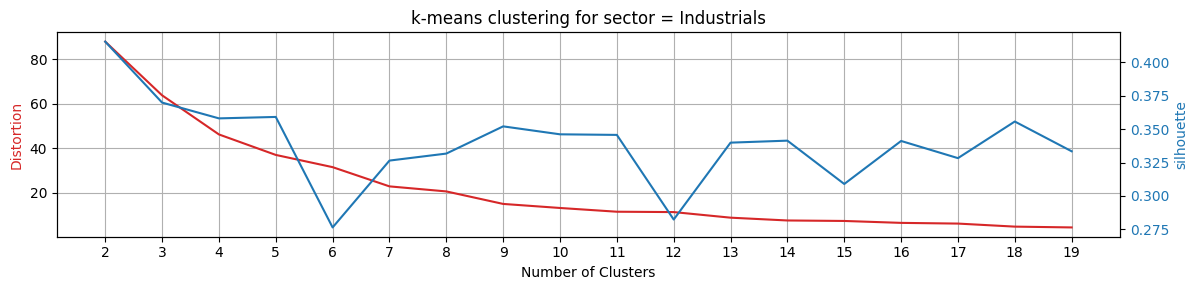

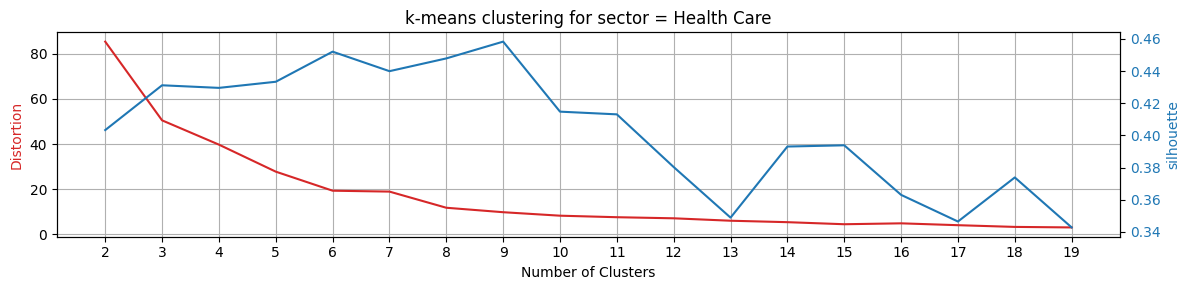

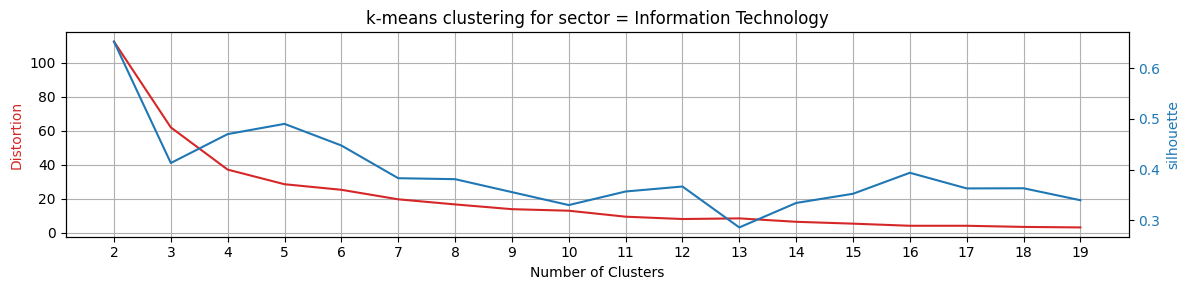

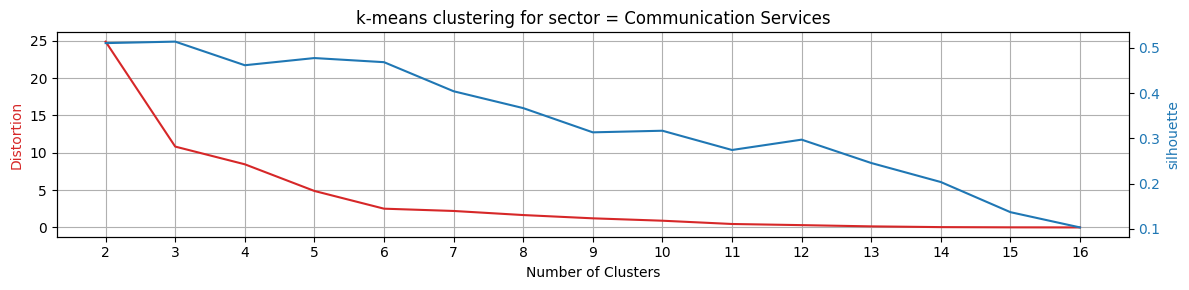

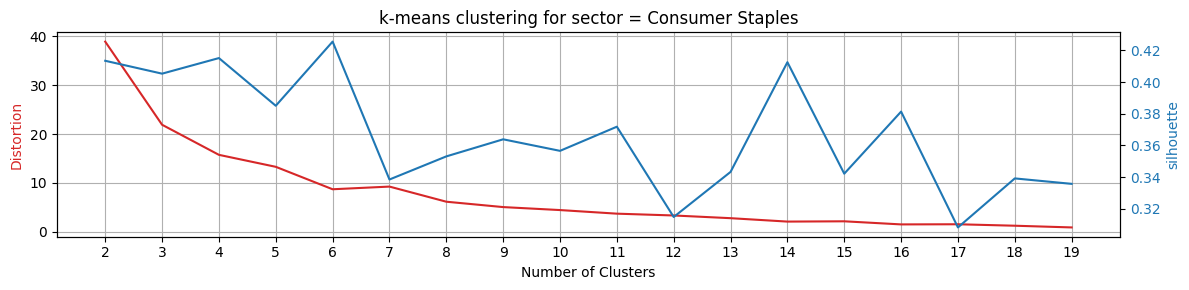

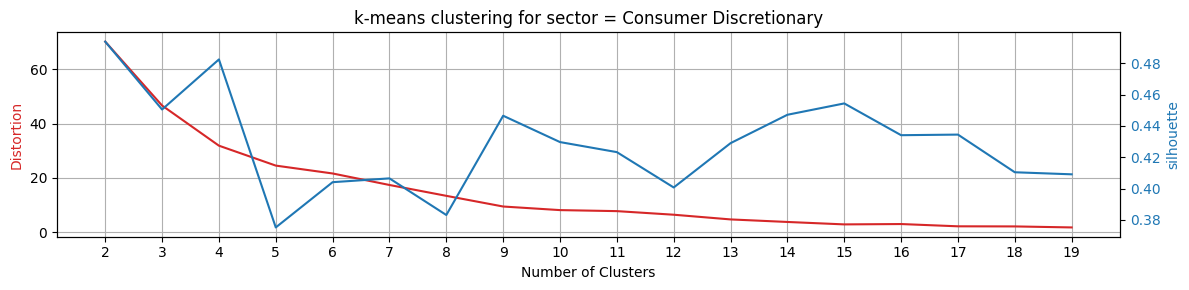

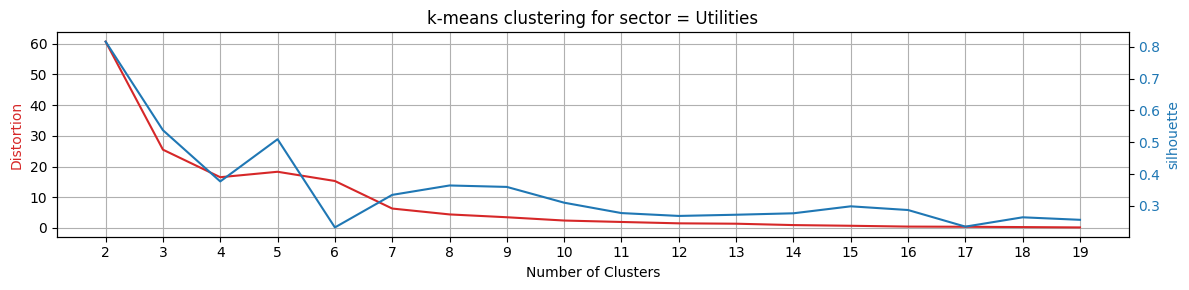

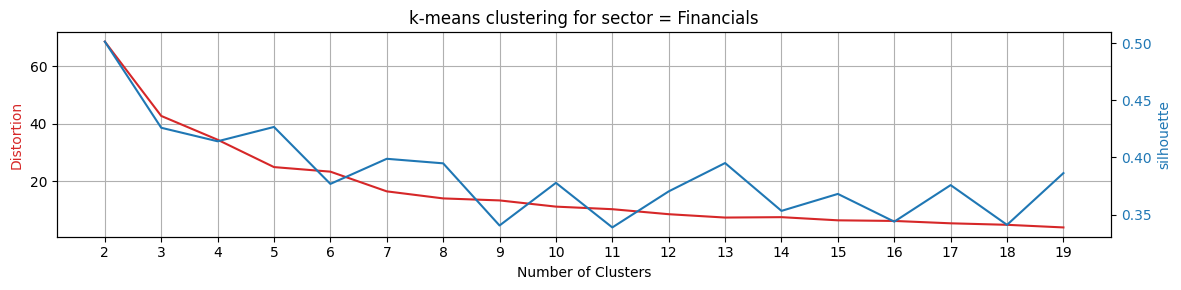

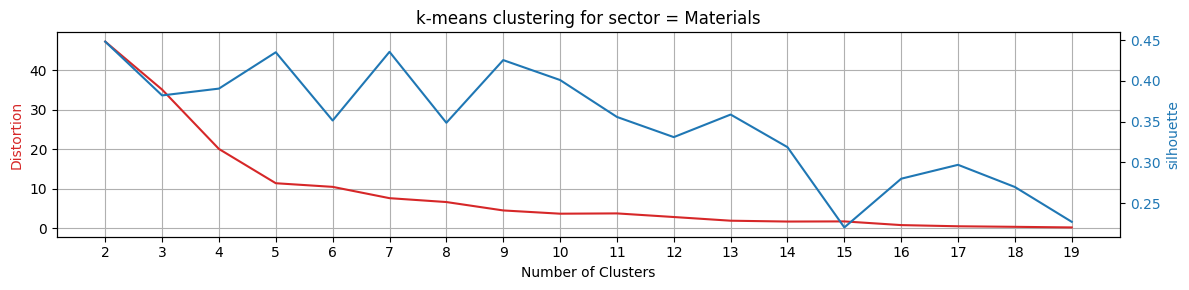

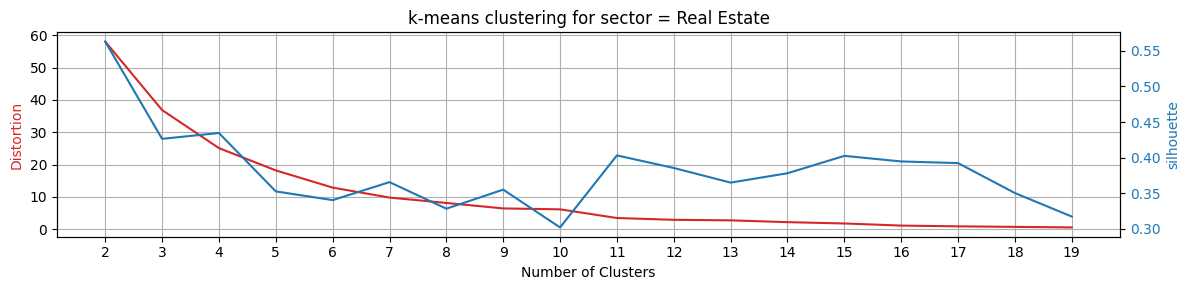

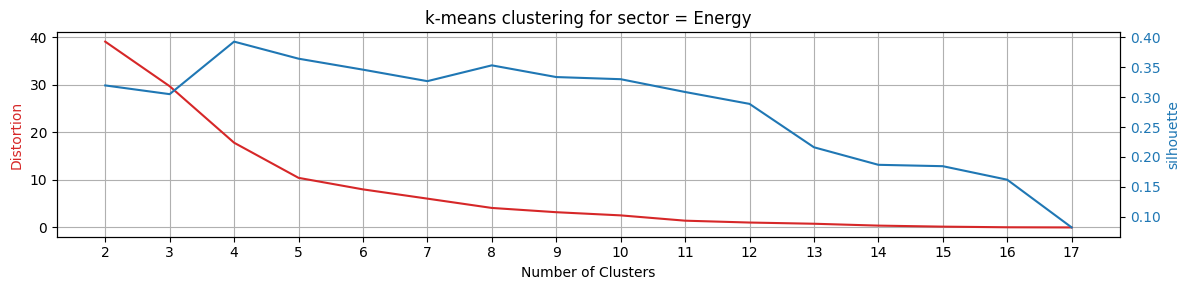

In [20]:
for sector in sectors:
    
    fig, ax1 = plt.subplots(figsize=(12, 3))
    
    color = 'tab:red'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Distortion',color=color)
    plt.grid(True)
    plt.title(f'k-means clustering for sector = {sector}')
    distorsions = []
    max_loop=20
    silhouette_score = []
    for k in range(2, max_loop):
        try:
            kmeans = KMeans(n_clusters=k,n_init='auto')
            kmeans.fit(df_norm['train'][sector].loc[:,['Mean','Volatility']])
            distorsions.append(kmeans.inertia_)
            silhouette_score.append(metrics.silhouette_score(df_norm['train'][sector].loc[:,['Mean','Volatility']],
                                                             kmeans.labels_,
                                                             random_state=10))
        except:
            max_loop=k
            break

    distorsions = distorsions[:len(silhouette_score)]
    ax1.plot(range(2, max_loop), distorsions,color=color)
    ax2 = ax1.twinx()
    
    color='tab:blue'
    ax2.set_ylabel('silhouette',color=color)
    ax2.plot(range(2, max_loop), silhouette_score,color=color)
    ax2.tick_params(axis='y',labelcolor=color)
    
    fig.tight_layout()
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.show()


Below we visualize the result of our clustering analysis. The variable **num_clusters_kmeans** contains our results for the optimal value of k given the above results.

In the below plot we color each datapoint by the cluster it belongs to. We observe that, for the most part, k-means clustering appears to group the stocks into coherent clusters. One problem with this method is that we need to put in by hand how many clusters we think there are. It would be better if we had a clustering method which could automatically determine the number of cluster! We will turn to one such method in the next subsection.

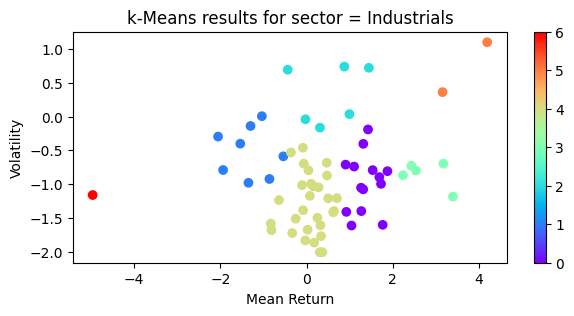

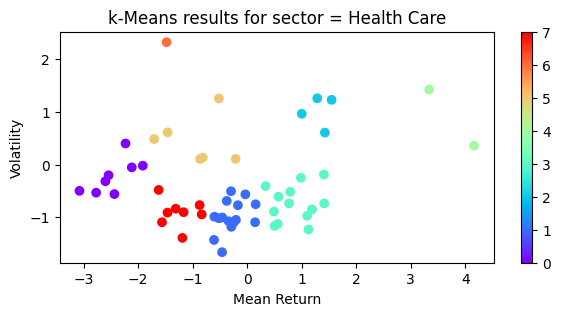

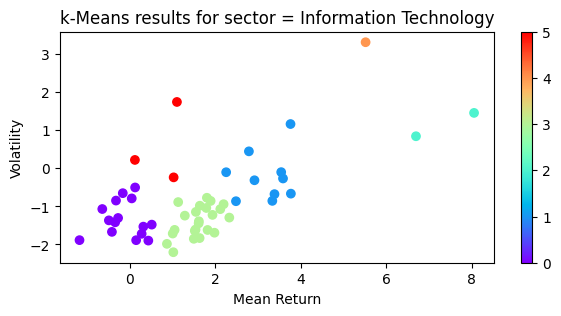

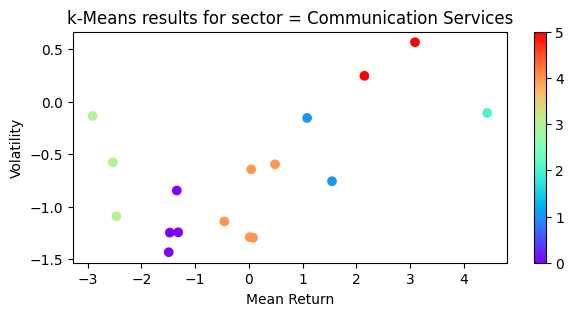

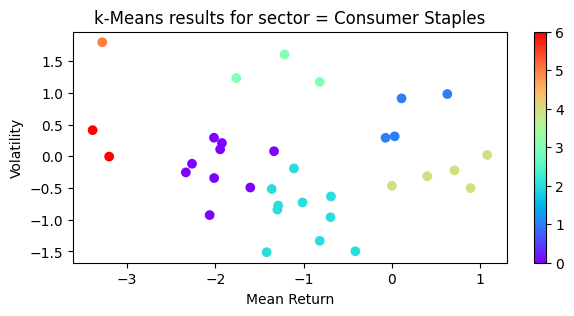

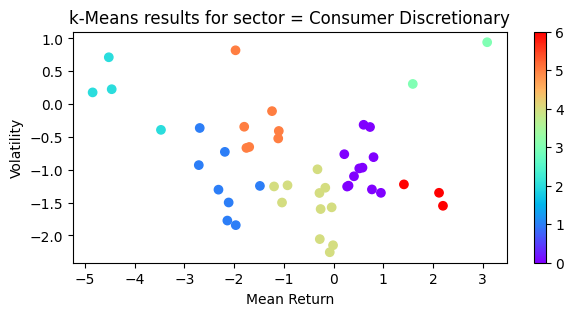

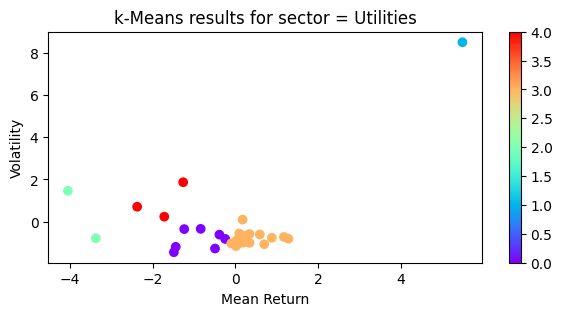

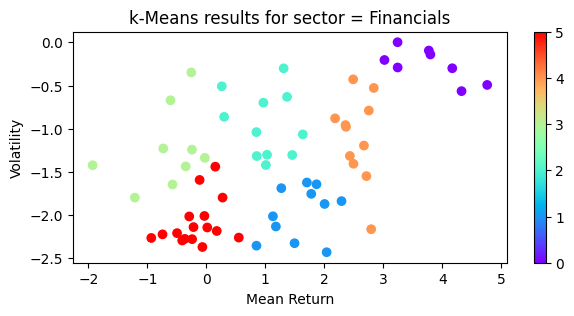

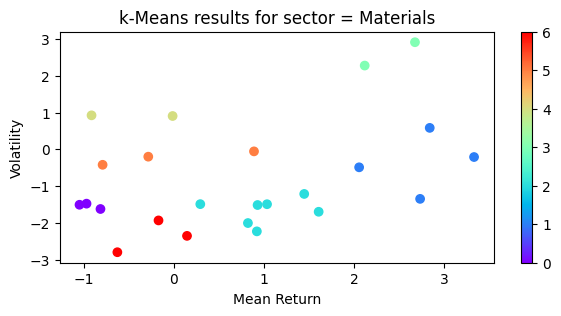

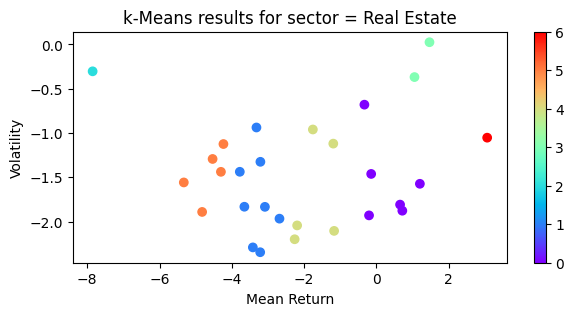

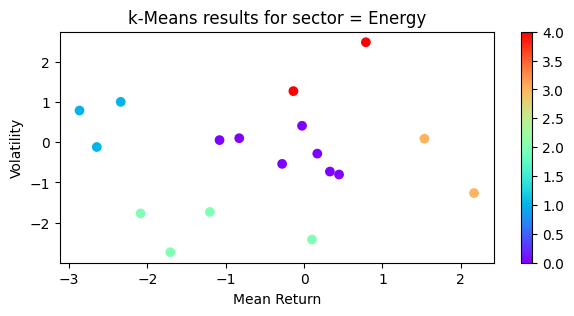

In [23]:
num_clusters_kmeans = [7,8,6,6,7,7,5,6,7,7,5]

for i, sector in enumerate(sectors):
    
    X = df_norm['train'][sector]
    
    k_means = cluster.KMeans(n_clusters = num_clusters_kmeans[i],n_init=100)
    k_means.fit(X.loc[:,['Mean','Volatility']])
    target_labels = k_means.predict(X.loc[:,['Mean','Volatility']])
    

    centroids = k_means.cluster_centers_
    fig = plt.figure(figsize=(7,3))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(X.iloc[:,0],
                         X.iloc[:,1],
                         c = k_means.labels_, 
                         cmap ="rainbow")
    
    ax.set_title(f'k-Means results for sector = {sector}')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.colorbar(scatter)
    

### Hierarchical

In this section we use heirarchical, and specifically agglomerative, clustering to group stocks together. In agglomerative clustering we start by assigning each datapoint to its own unique cluster. We then proceed to group together the two clusters which are closest to each other, according to some notion of distance. The process terminates when we are left with a single cluster, corresponding to all the datapoints available. Here we use the Ward variance minimization algorithm, which is explained in the SciPy documentation <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html">here</a>.

For each sector we plot the resulting hierarchical clustering using the dendrogram function from SciPy. The different colors of the dendrogram plot correspond to different colors, according to the default values in SciPy for the color threshold, see the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html">documentation</a> for more details.

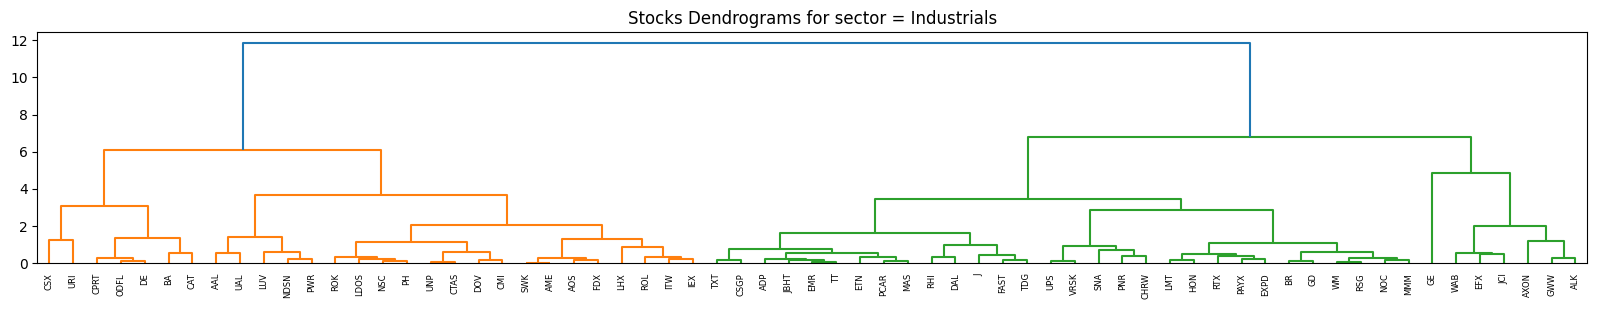

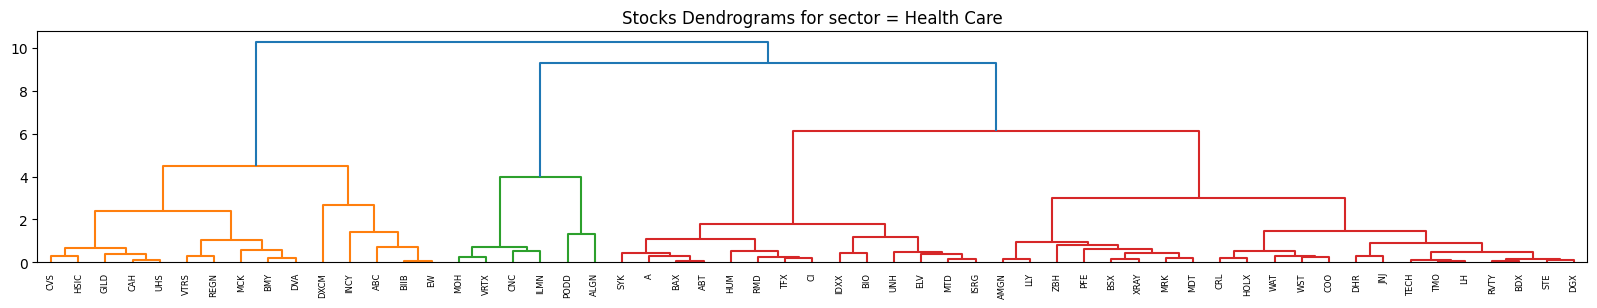

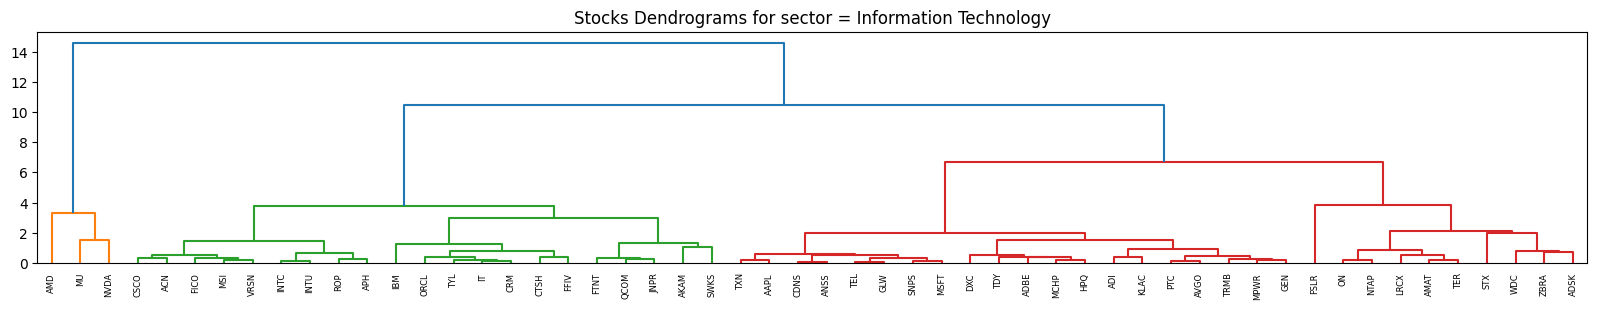

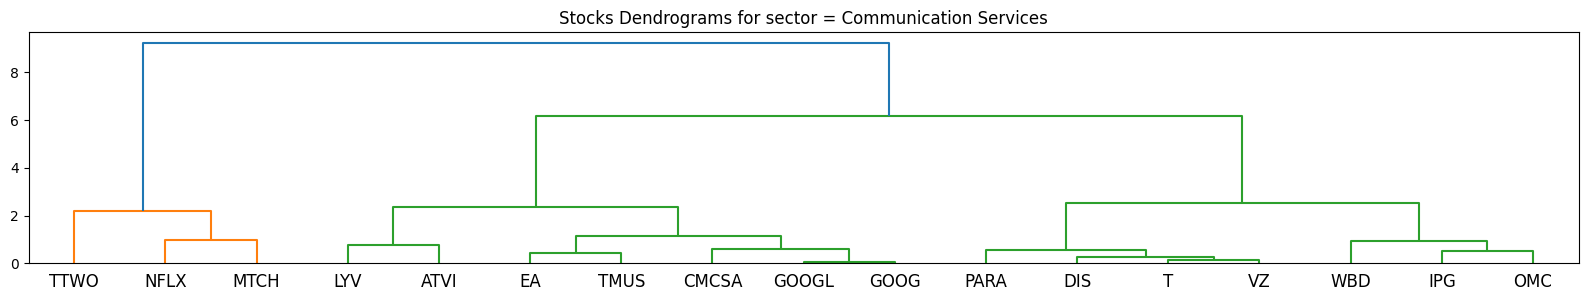

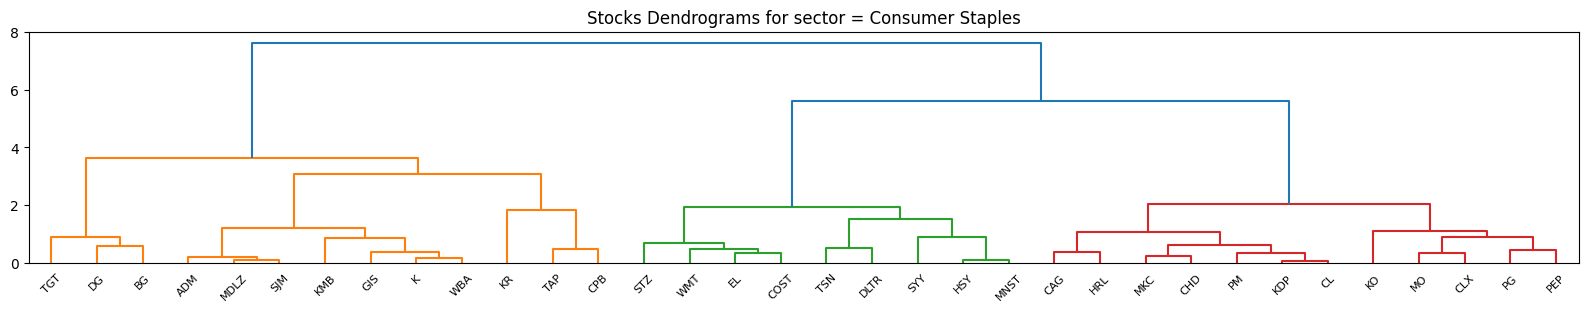

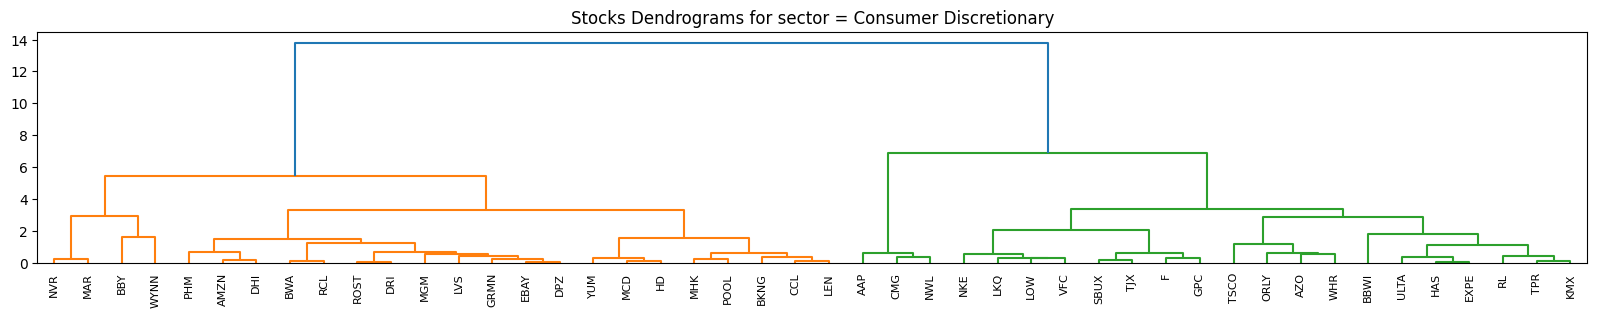

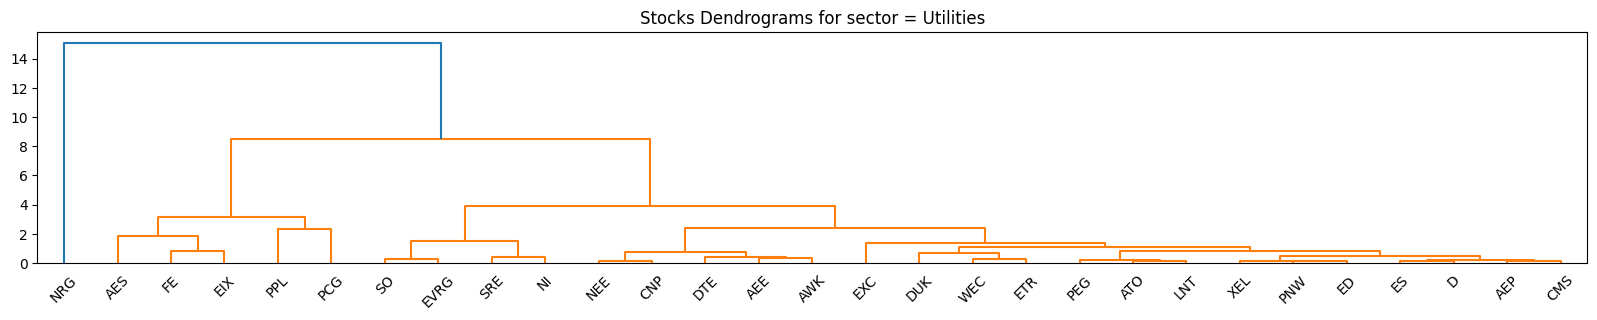

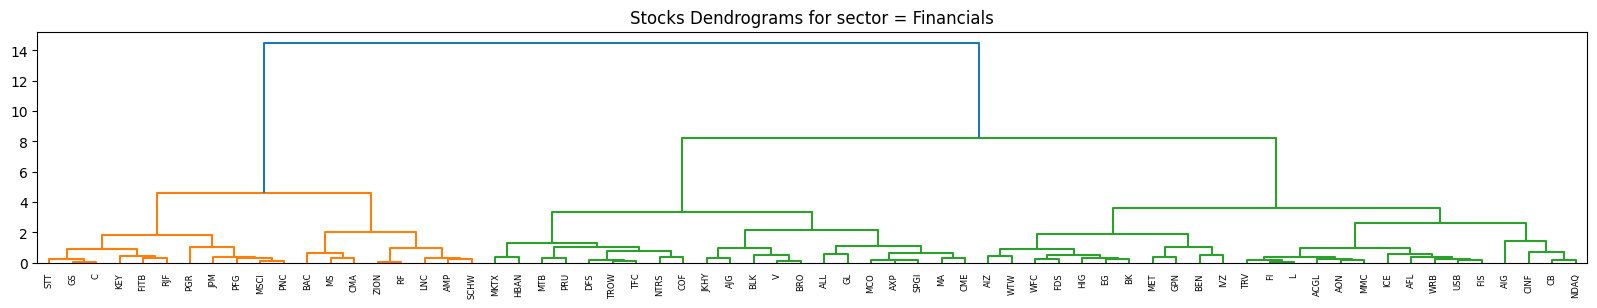

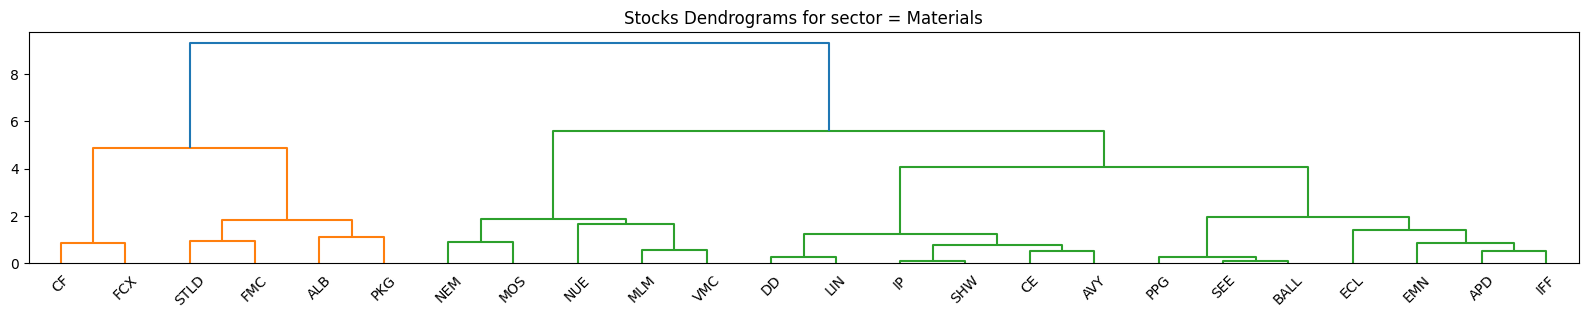

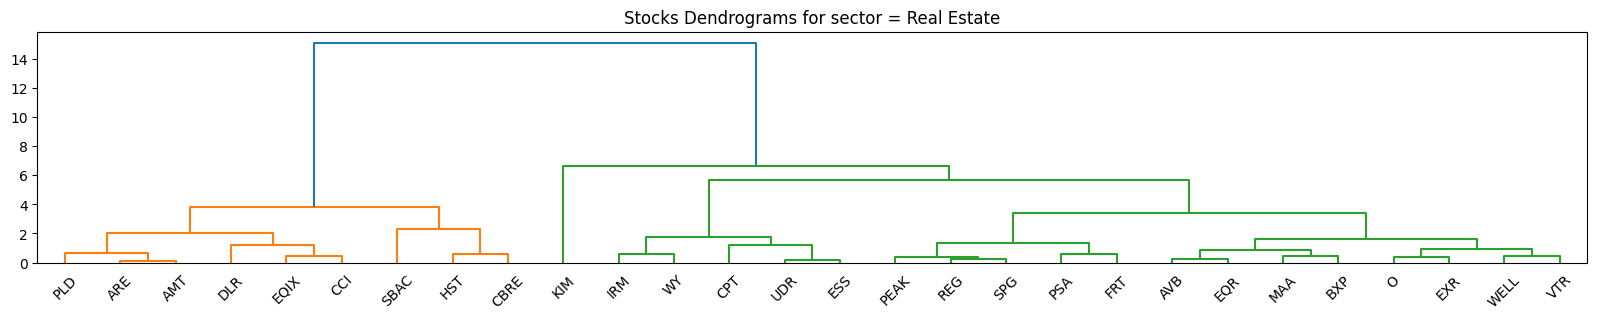

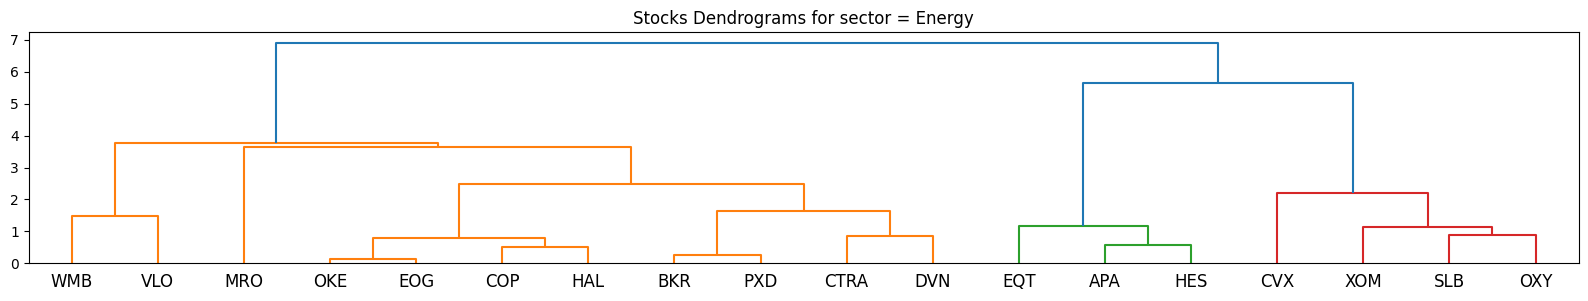

Total number of pairs to check: 5292.0


In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

# Z_sec is a dictionary which will contain the results of agglomerative clustering for
# each sector.
Z_sec = {}


for sector in sectors:
    #For each sector we cluster the stocks using Ward's distance.
    Z_sec[sector] = linkage(df_norm['train'][sector].loc[:,['Mean','Volatility']],
                            method='ward')
# Total pairs is the total number of pairs we need to check when we consider pair-trading.
total_pairs = 0
# num_clusters_dend will contain the number of clusters in a given sector.
num_clusters_dend = {}

for sector in sectors:
    # For each sector we 
    plt.figure(figsize=(20,3))
    plt.title(f"Stocks Dendrograms for sector = {sector}")
    
    dend = dendrogram(Z_sec[sector],
                      labels = df_norm['train'][sector].index)
    counts = Counter(dend['leaves_color_list'])

    num_clusters_dend[sector] = len(counts)
    
    for x in counts.values():
        total_pairs += x*(x-1)*1/2.
    plt.show()
    
print(f'Total number of pairs to check: {total_pairs}')

### Affinity Propagation

In this section we cluster the stocks using the <a href="https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation">affinity propagation</a> algorithm. This is an interesting proposed in 2007 by Brendan Frey and Delbert Dueck which is inspired by message passing. The goal of the affinity propagation algorithm is to find a set of "exemplars", which are the set of points which are the most representative for other data-points. One useful feature of affinity propagation is we do not need to choose the number of clusters beforehand or have to choose where to cut our dendrogram.

In affinity propagation we start with a similarity function $s(i,j)$ which measures how similar two data-points $x_i$ and $x_j$ are to each other. If $s(i,j)>s(j,k)$ than $x_j$ is more similar to $x_i$ than to $x_k$. The affinity propagation algorithm starts with two matrices, $r(i,j)$ and $a(i,j)$. Roughly speaking, $r(i,j)$ is the accumulated evidence that $x_j$ should be an exemplar for $x_i$ and $a(i,j)$ is the accumulated evidence that $x_i$ should choose $x_j$ to be its exemplar. A datapoint $x_j$ is only chosen to be an exemplar if it is similar enough to the other data-points in the cluster and enough data-points choose $x_j$ to be their examplar.

The formal algorithm is as follows. First, at time $t=0$ we set $r_{t=0}(i,j)=a_{t=0}(i,j)=0$. The updates to $r$ and $a$ are:
\begin{align}
\delta r_{t+1}(i,k) = s(i,k)-\text{max}_{k\neq k'}\left[a_t(i,k') + s(i,k')\right]
\end{align}
\begin{align}
\delta a_{t+1} = \text{min}\left[0,r(k,k)+\sum_{i' \neq \{i,k\}} r(i',k)\right]
\end{align}
Then we define a dampening factor $\lambda$ and the new values of $r$ and $a$ are:
\begin{align}
r_{t+1}(i,k) = \lambda r_{t}(i,k) +(1-\lambda)\delta r_{t+1}(i,k)
a_{t+1}(i,k) = \lambda a_{t}(i,k) +(1-\lambda)\delta a_{t+1}(i,k)
\end{align}
The dampening factor is introduced to improve the numerical convergence of this algorithm. 

Finally, the criterion matrix is defined by $C(i,j)=r(i,j)+a(i,j)$. The exemplars are defined to be the datapoints $x_i$ for which $C(i,i)>0$, i.e. they correspond to the positive diagonal elements. The exemplar for datapoint $x_i$ is given by $\text{exemplar}(x_i)=\text{arg max}_{j}C(i,j)$, i.e. for a fixed $i$ we choose the $j$ which maximizes $C(i,j)$.

Total number of pairs to check: 1778.0


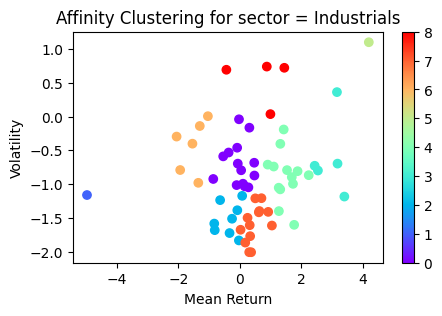

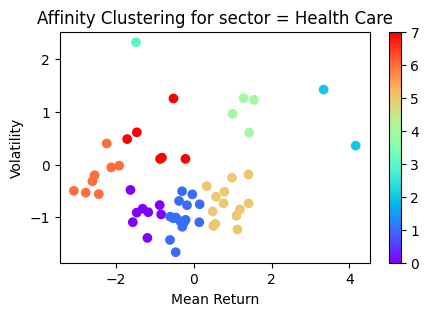

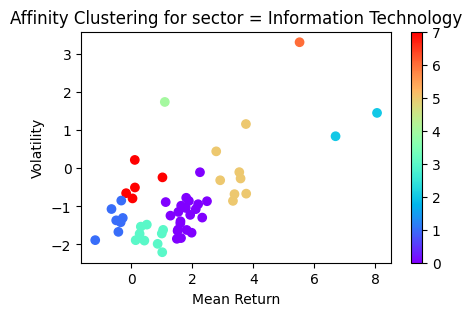

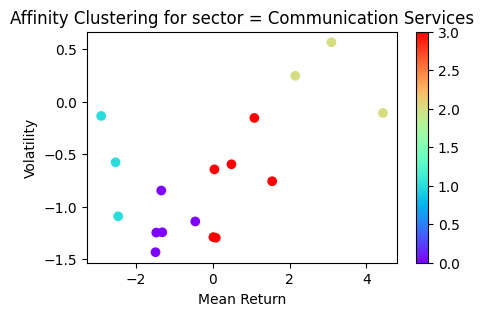

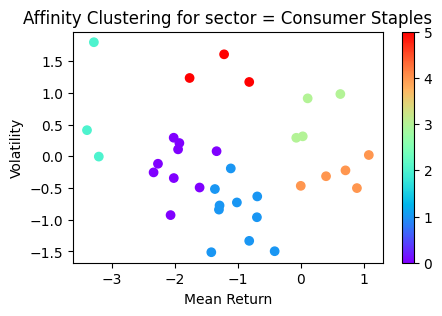

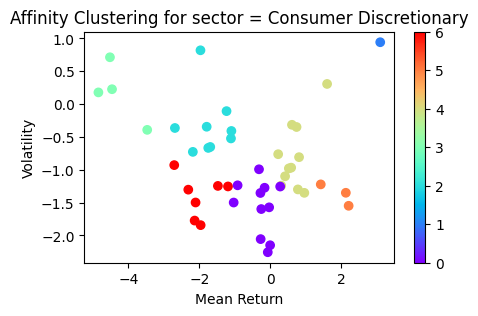

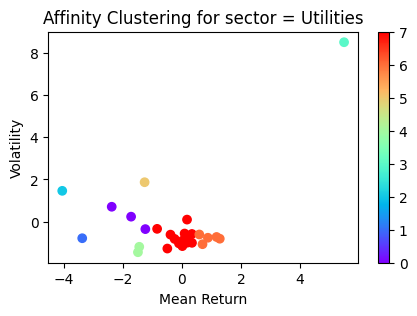

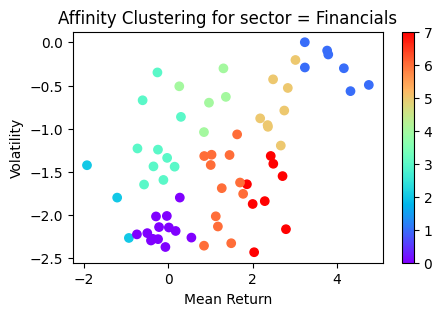

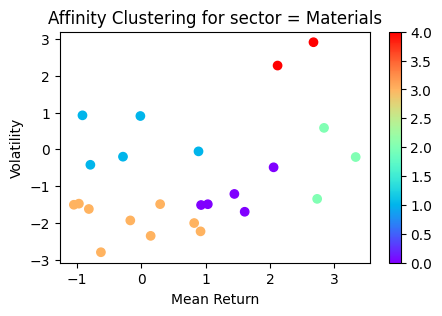

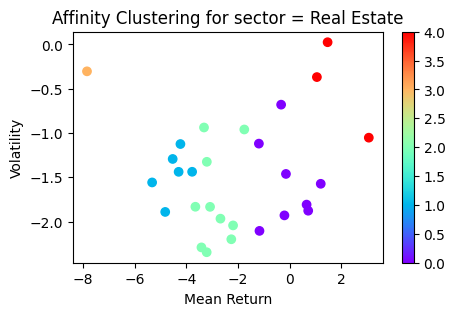

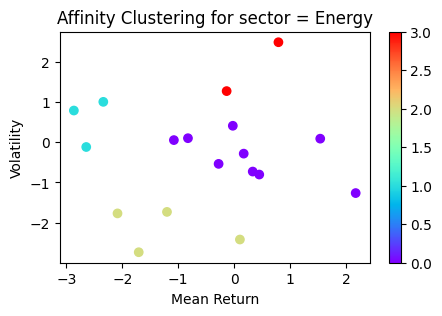

In [26]:
clust_labels_ap = {}
tot_pairs = 0

for sector in sectors:
    ap = AffinityPropagation()
    ap.fit(df_norm['train'][sector].loc[:,['Mean','Volatility']])
    clust_labels_ap[sector] = ap.predict(df_norm['train'][sector].loc[:,['Mean','Volatility']])
    
    for x in Counter(clust_labels_ap[sector]).values():
        tot_pairs += x*(x-1)*.5

print(f'Total number of pairs to check: {tot_pairs}')
        
for sector in sectors:

    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df_norm['train'][sector].iloc[:,0],df_norm['train'][sector].iloc[:,1], c= clust_labels_ap[sector], cmap ="rainbow")
    ax.set_title('Affinity')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.colorbar(scatter)
    plt.title(f'Affinity Clustering for sector = {sector}')

### Optics

The final example we consider is the OPTICS (Ordering Points To Identify the Clustering Structure) algorithm, which is inspired by the DBSCAN algorithm. The benefit of the OPTICS algorithm is that it can more easily handle clusters of different densities. Like the affinity propagation algorithm, we do not need to determine the number of clusters by hand. In addition, OPTICS does not assign every point to a cluster, if a data-point cannot be assigned to a cluster it is given a label of -1. This is particularly useful for pairs trading since we want to minimize the number of datapoints we consider.

We will not go through the full OPTICS algorithm but we will explain the basic ideas here. The $\epsilon$-neighborhood of a point is defined by:
\begin{align}
N_{\epsilon}(q)=\{p\in X|d(q,p)\leq \epsilon\}.
\end{align}
A core point $q$ defined by the condition:
\begin{align}
|N_{\epsilon}(q)|\geq \text{minPts}
\end{align}
where $|N_{\epsilon}(q)|$ is the number of points in the $\epsilon$-neighborhood of $q$ and $\text{minPts}$ is a free parameter we can choose. Note that to define a core point we need two free parameters, $\epsilon$ and $\text{minPts}$.

The core-distance of a point $p$ is defined by:
\begin{align}
\text{core-dist}_{\epsilon,\text{minPts}}(p)=\begin{cases}
  \text{Undefined} & \text{if} |N_{\epsilon}(q)|<\text{minPts} \\
  \text{minPts-distance}(p) & \text{otherwise}
\end{cases}
\end{align}
where $\text{minPts-distance}(p)$ is the distance from a point $p$ to its $\text{minPts}^{\text{th}}$ closest neighbor. In other words, the core-distance $\epsilon'$ is the smallest distance such that $p$ is a core-point with respect the pair $(\epsilon',\text{minPts})$.

The reachability distance is defined by:
\begin{align}
\text{reach-dist}_{\epsilon,\text{minPts}}(p,o)=\begin{cases}
  \text{Undefined} & \text{if} |N_{\epsilon}(o)|<\text{minPts} \\
  \text{max}\left(\text{core-dist}_{\epsilon,\text{minPts}}(o),\text{distance}(o,p)\right)& \text{otherwise}
\end{cases}
\end{align}

The OPTICS algorithm then groups the data-points together such that data-points which are close to each other (as measured by our distance metric) and have similar reachability-distances are grouped together. We then make a plot of the data-points on the x-axis versus the reachability distance. In this 2d plot the clusters correspond to valleys while the boundaries between clusters correspond to sudden increases in the reachability distance. A useful visualization of this plot can be found here <a href="https://en.wikipedia.org/wiki/OPTICS_algorithm#Extracting_the_clusters">here</a>. To identify a cluster on this we need to specify a minimum steepness on the plot which signifies a change in cluster. Here we will use the default value provided by the SciPy optimization (we will also take $\text{minPts}=2$ and $\epsilon = \infty$).

**Note:** to make the plots simple we will not plot points which do not belong to any cluster.

Need to check 372.0 pairs


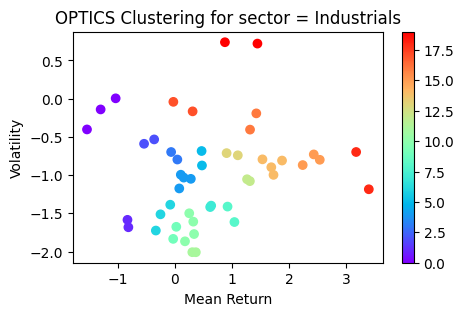

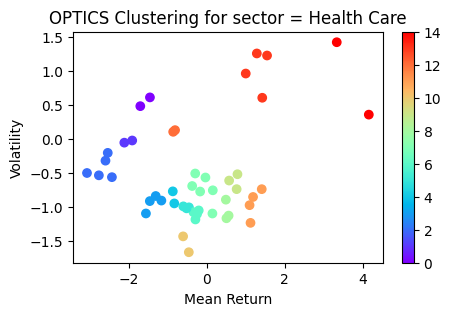

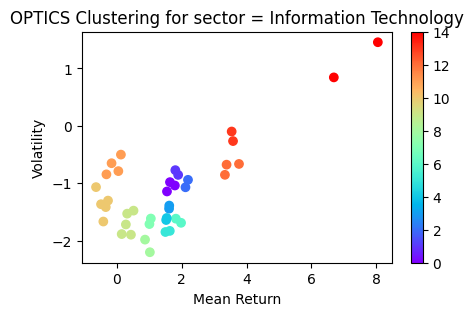

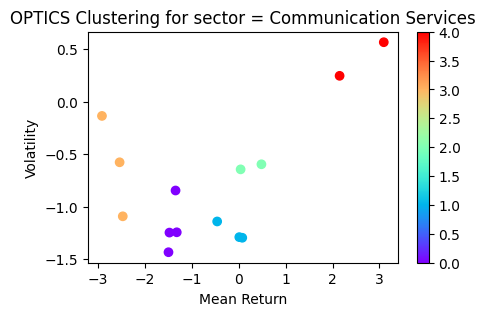

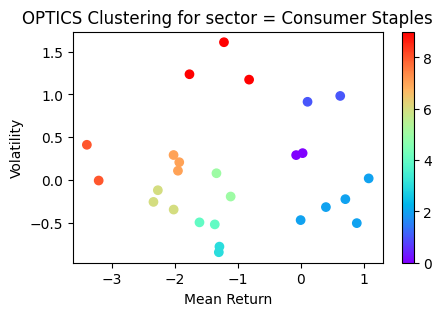

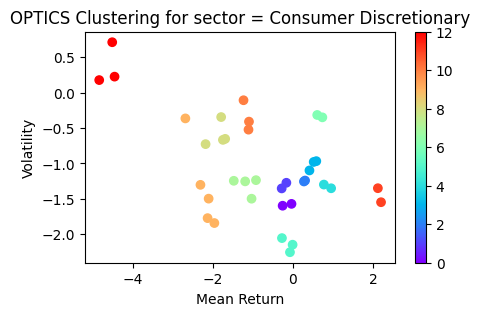

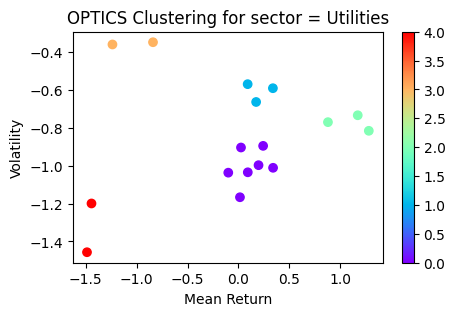

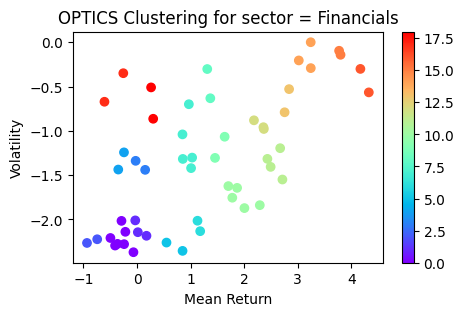

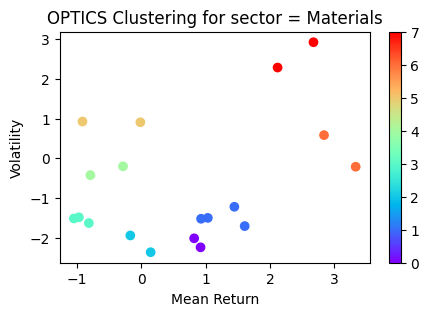

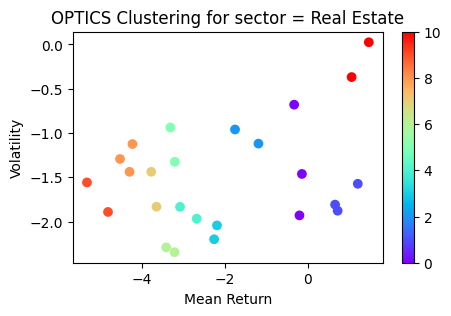

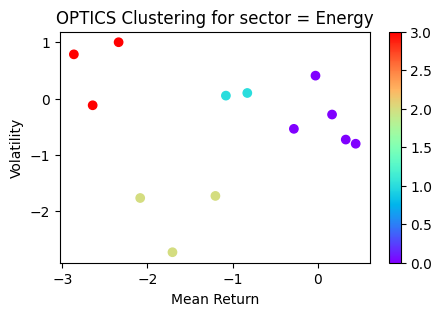

In [27]:
optics_labels = {}
sector_counts = {}

for sector in sectors:
    X = df_norm['train'][sector].loc[:,['Mean','Volatility']]
    
    optics_labels[sector] = OPTICS(min_samples=2).fit_predict(X)
    sector_counts[sector] = 0

    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    
    datapoints = list(zip(df_norm['train'][sector].iloc[:,0],df_norm['train'][sector].iloc[:,1],optics_labels[sector]))
    datapoints = np.array([data for data in datapoints if data[-1]!=-1])
    
    scatter = ax.scatter(datapoints[:,0],datapoints[:,1],c=datapoints[:,2],cmap='rainbow')
    
    #scatter = ax.scatter(df_norm['train'][sector].iloc[:,0],
    #                     df_norm['train'][sector].iloc[:,1],
    #                     c = optics_labels[sector],
    #                     cmap ="rainbow")
   
    ax.set_title('Optical Clustering')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.title(f'OPTICS Clustering for sector = {sector}')
    
    plt.colorbar(scatter)
    
    counts = Counter(optics_labels[sector])
    for label, count in counts.items():
        if label == -1:
            continue
        else:
            sector_counts[sector] += count*(count-1)*.5
        
print(f'Need to check {sum(list(sector_counts.values()))} pairs')

## Features = [Mean, Volatility, Skew, Kurtosis]

In the subsections below we will repeat our previous analysis, but now include skew and kurtosis as features when clustering the data. We will also continue to visualize our clusters using 2d plots where plot the different stocks as a function of mean and volatility. These clusters will appear to be less clean than our earlier results simply because we are not plotting all the available features.

### K-means

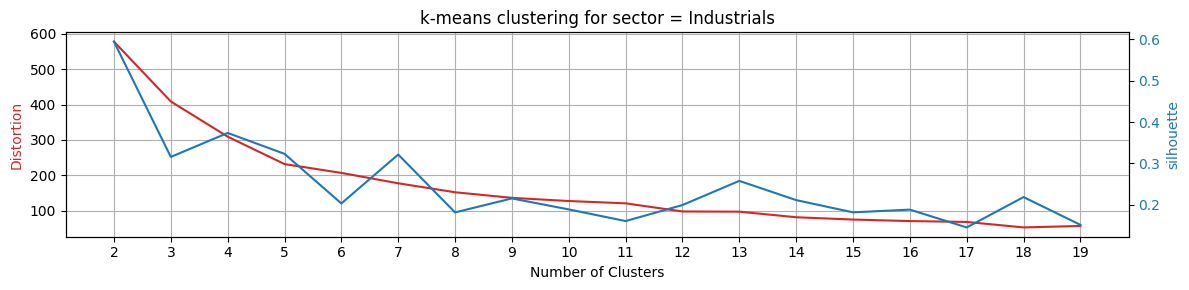

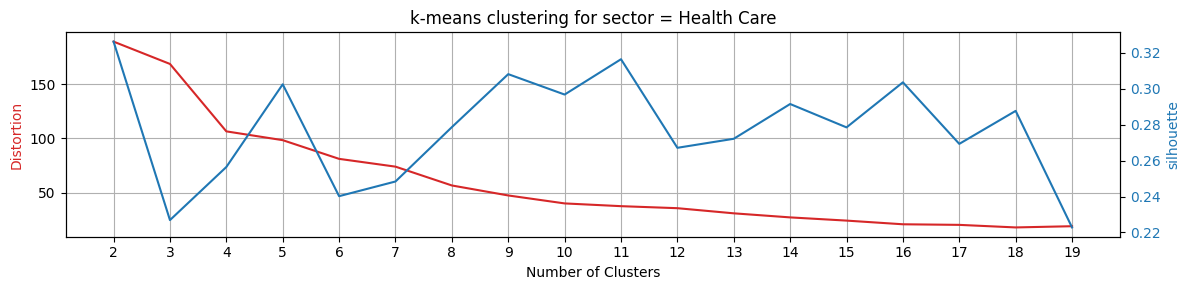

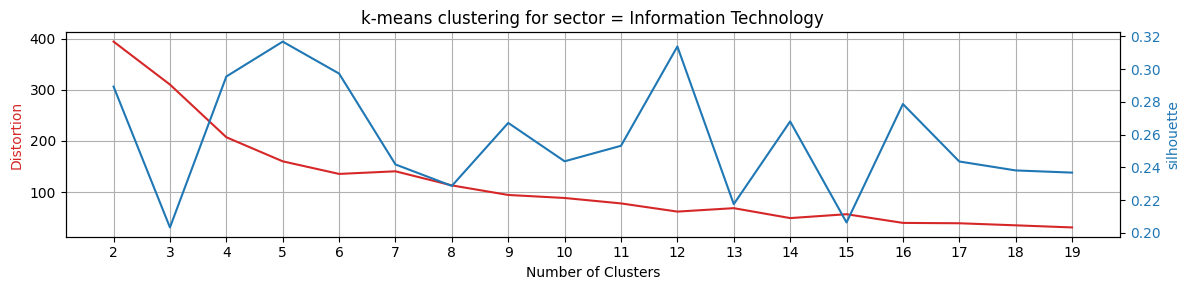

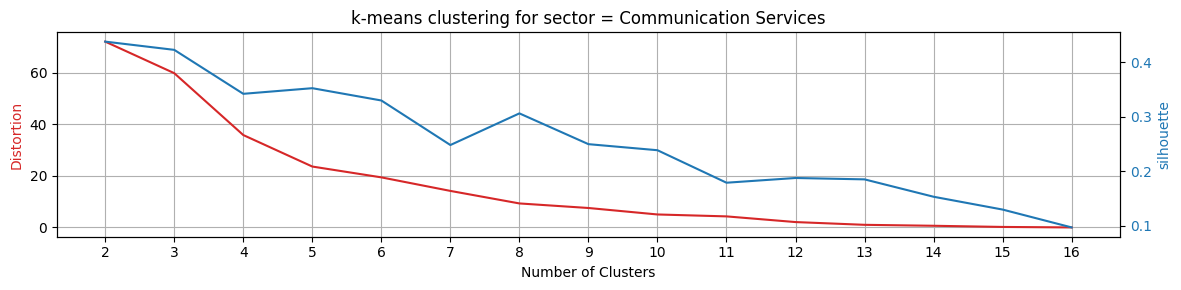

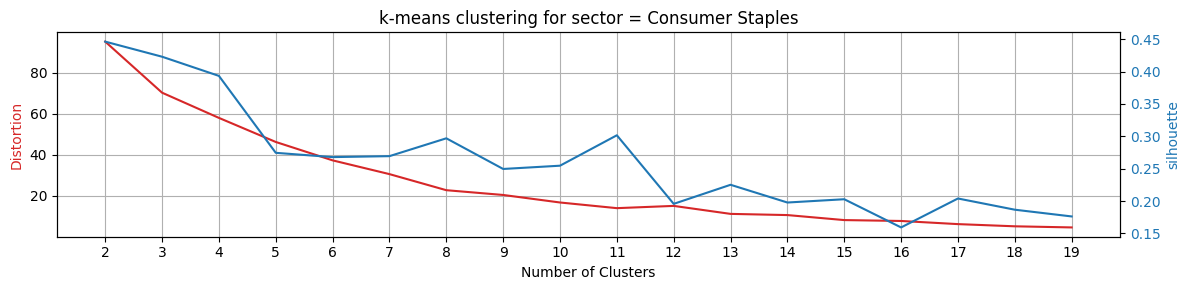

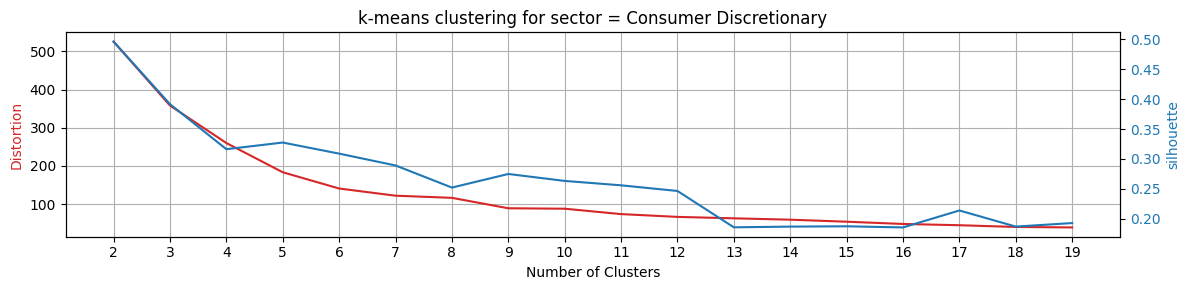

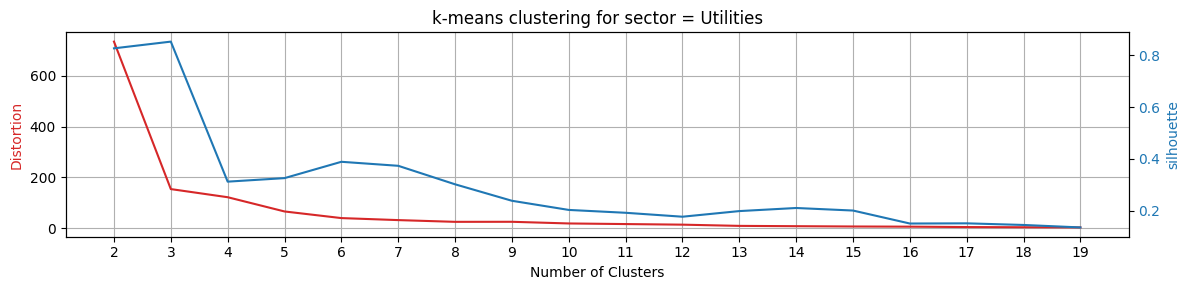

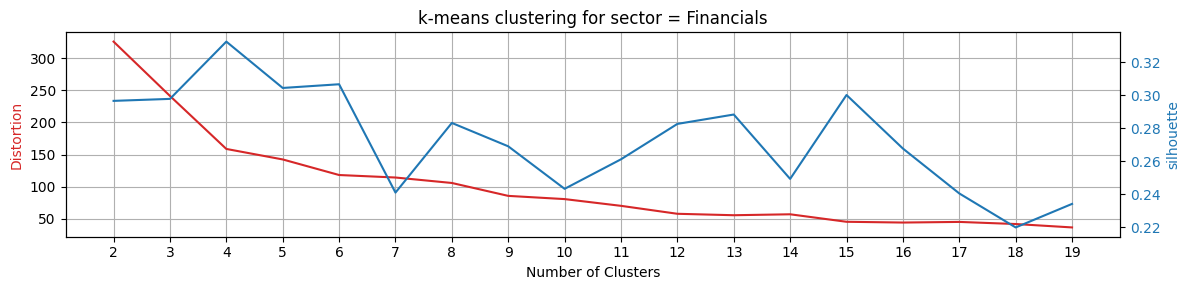

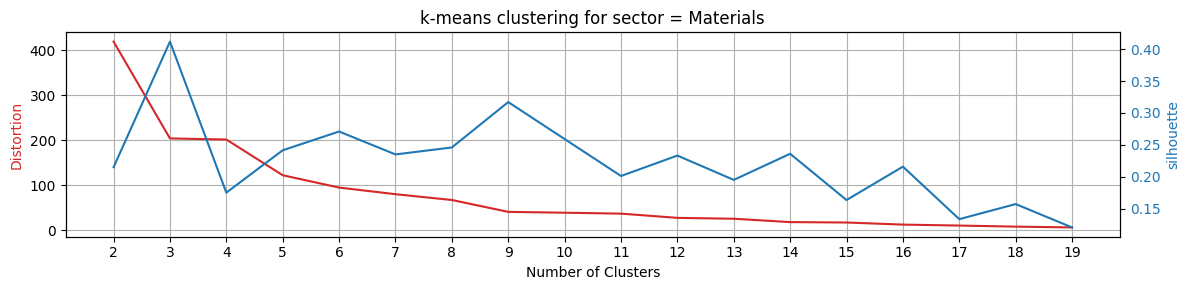

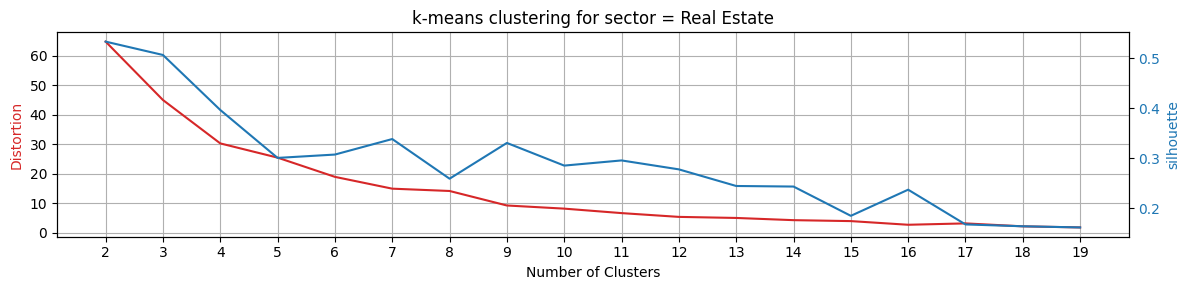

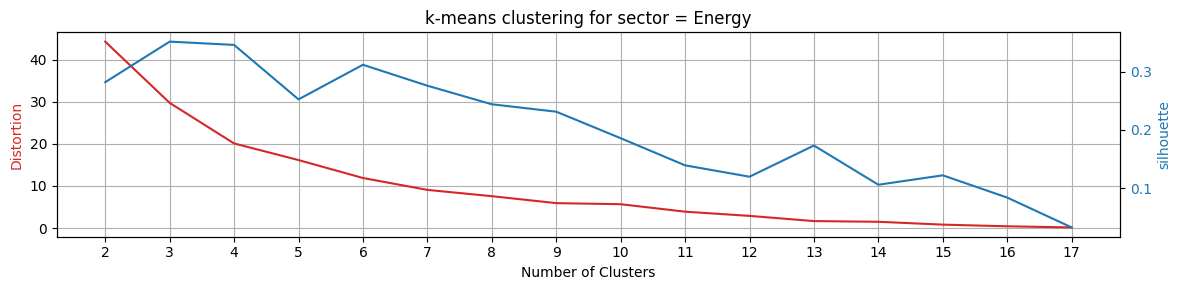

In [28]:
for sector in sectors:
    
    fig, ax1 = plt.subplots(figsize=(12, 3))
    
    color = 'tab:red'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Distortion',color=color)
    plt.grid(True)
    plt.title(f'k-means clustering for sector = {sector}')
    distorsions = []
    max_loop=20
    silhouette_score = []
    for k in range(2, max_loop):
        try:
            kmeans = KMeans(n_clusters=k,n_init='auto')
            kmeans.fit(df_norm['train'][sector])
            distorsions.append(kmeans.inertia_)
            silhouette_score.append(metrics.silhouette_score(df_norm['train'][sector],
                                                             kmeans.labels_,
                                                             random_state=10))
        except:
            max_loop=k
            break

    distorsions = distorsions[:len(silhouette_score)]
    ax1.plot(range(2, max_loop), distorsions,color=color)
    ax2 = ax1.twinx()
    
    color='tab:blue'
    ax2.set_ylabel('silhouette',color=color)
    ax2.plot(range(2, max_loop), silhouette_score,color=color)
    ax2.tick_params(axis='y',labelcolor=color)
    
    fig.tight_layout()
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.show()


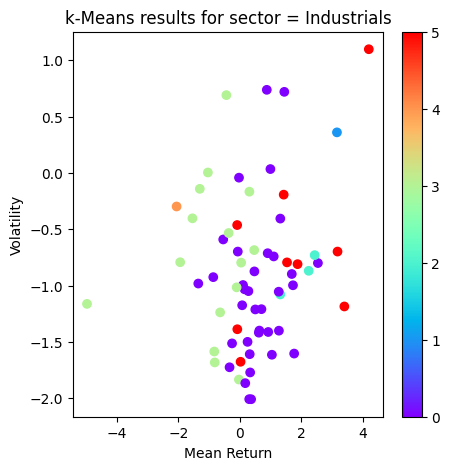

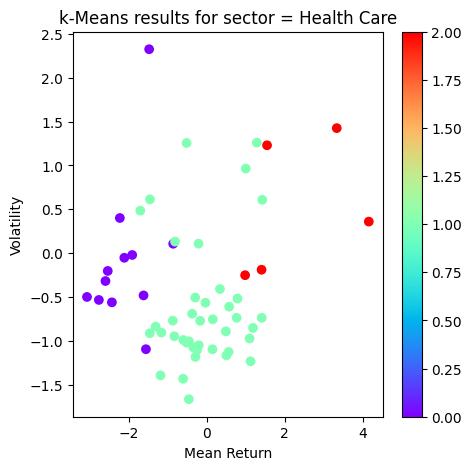

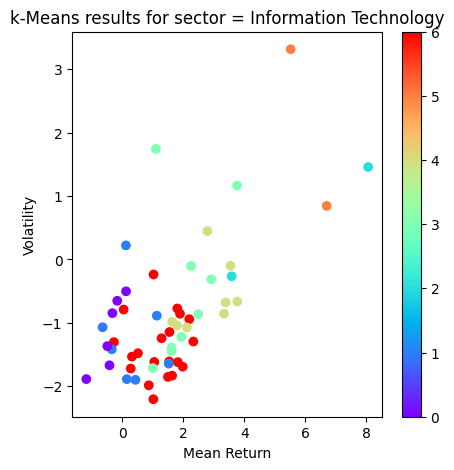

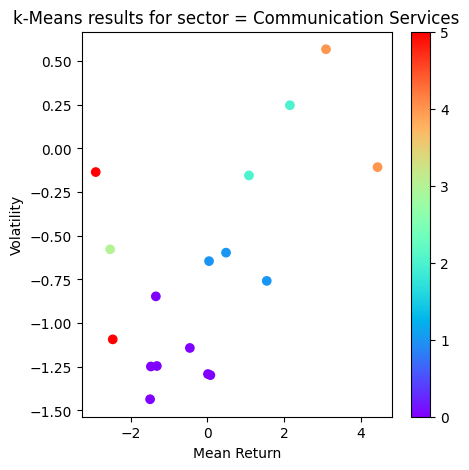

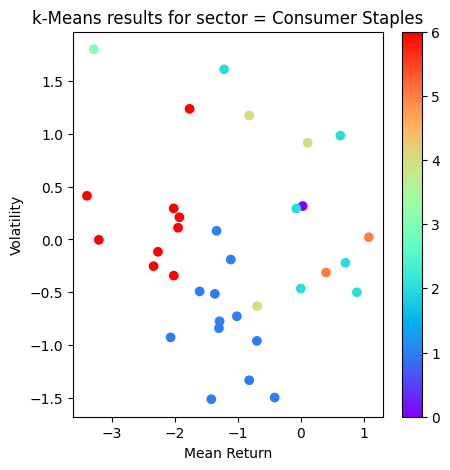

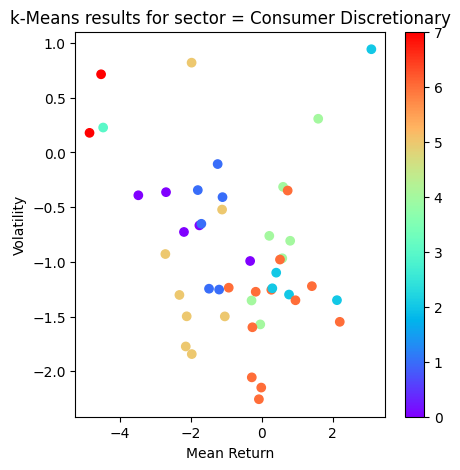

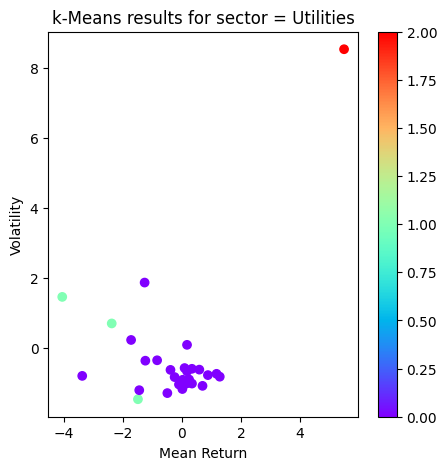

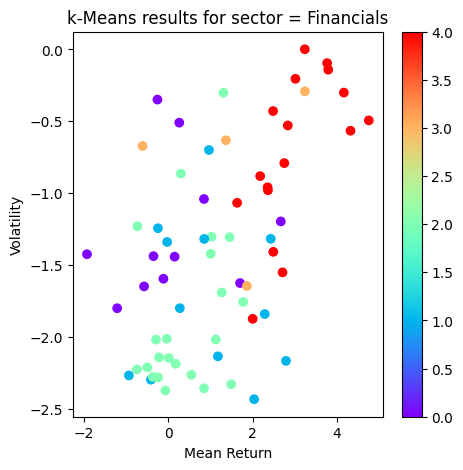

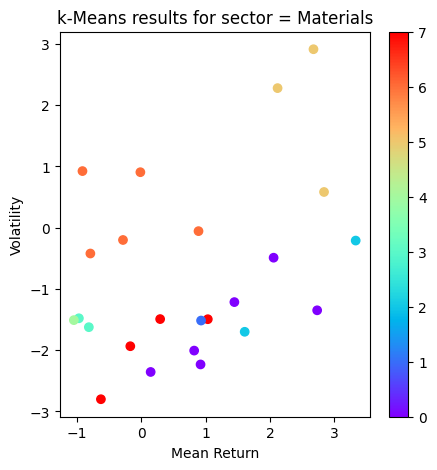

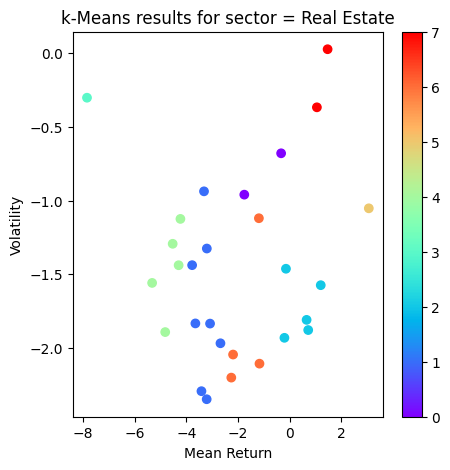

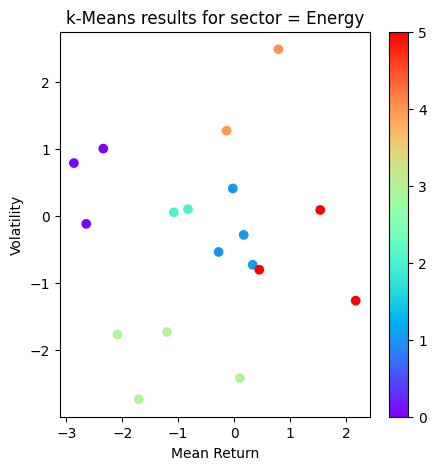

In [645]:
num_clusters_kmeans = [6,3,7,6,7,8,3,5,8,8,6]

for i, sector in enumerate(sectors):
    
    X = df_norm['train'][sector]
    
    k_means = cluster.KMeans(n_clusters = num_clusters_kmeans[i],n_init=100)
    k_means.fit(X)
    target_labels = k_means.predict(X)
    

    centroids = k_means.cluster_centers_
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(X.iloc[:,0],
                         X.iloc[:,1],
                         c = k_means.labels_, 
                         cmap ="rainbow")
    
    ax.set_title(f'k-Means results for sector = {sector}')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.colorbar(scatter)

### Hierarchical

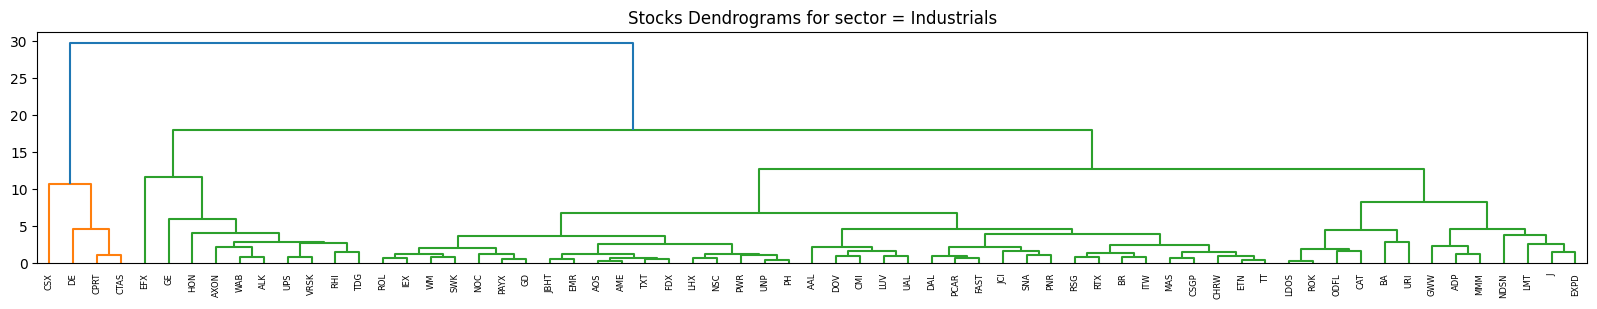

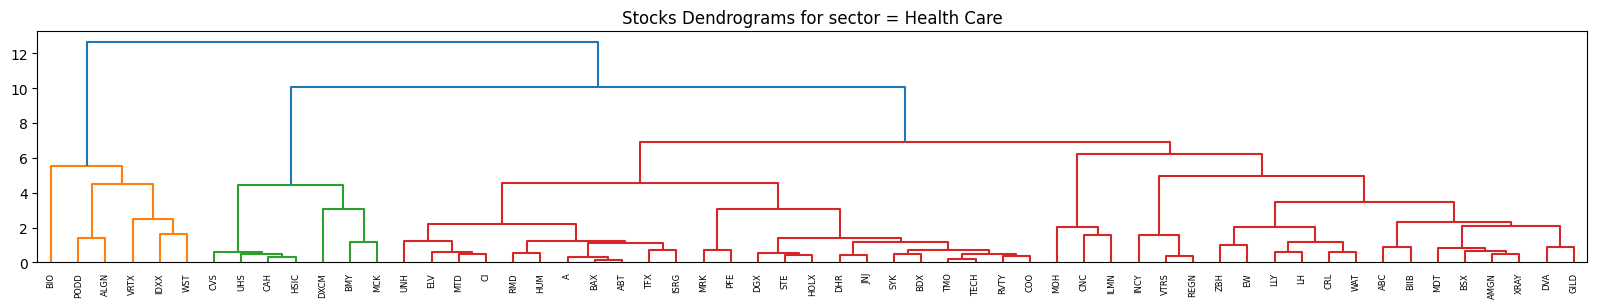

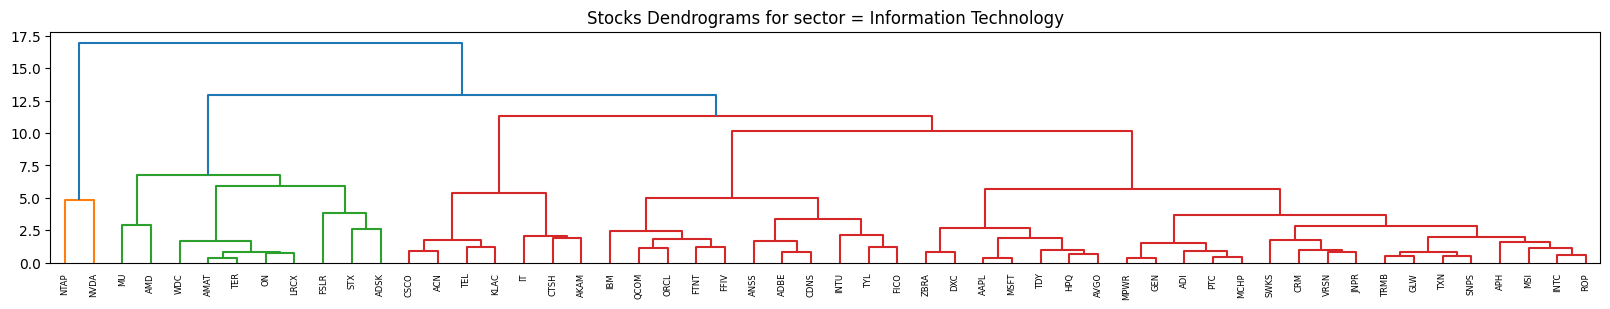

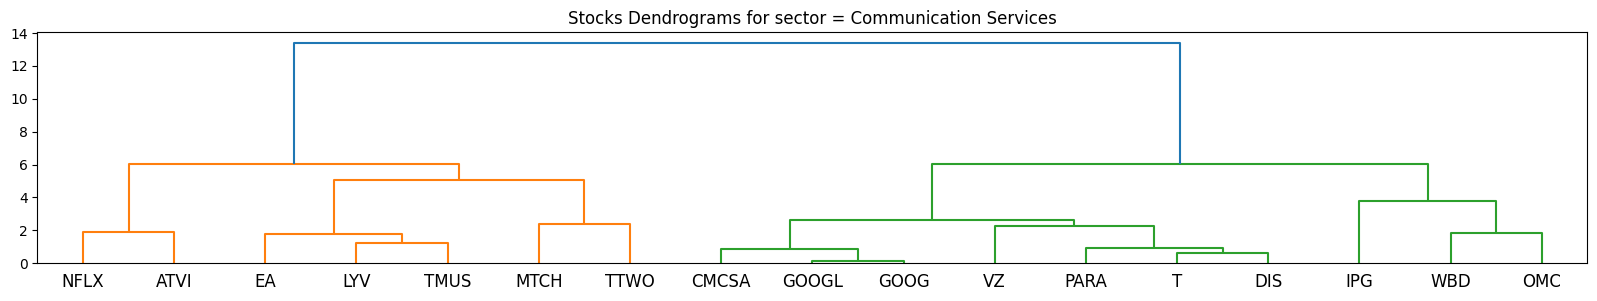

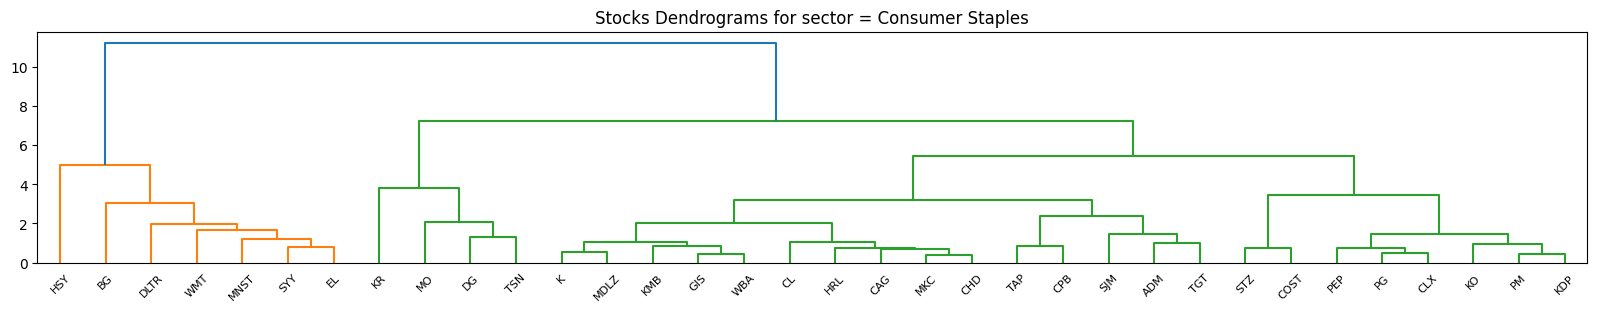

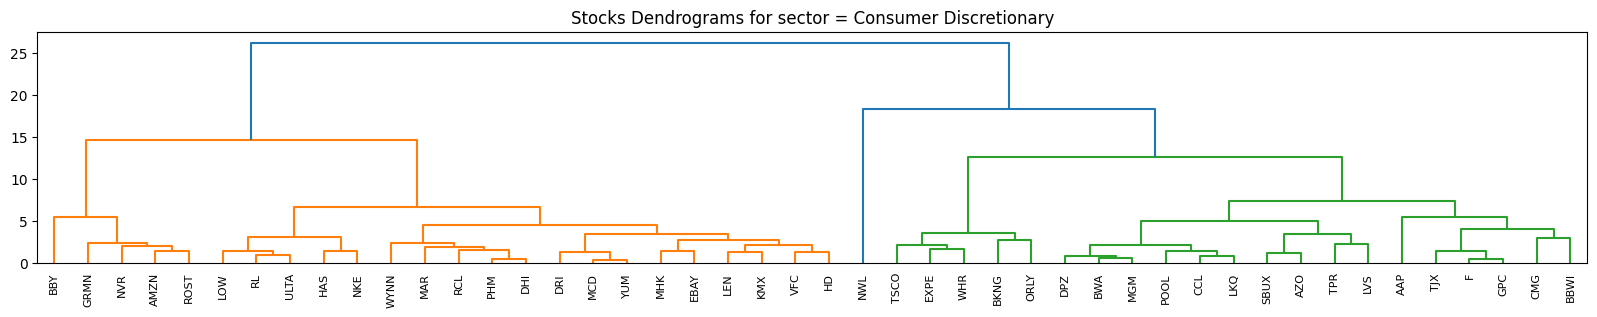

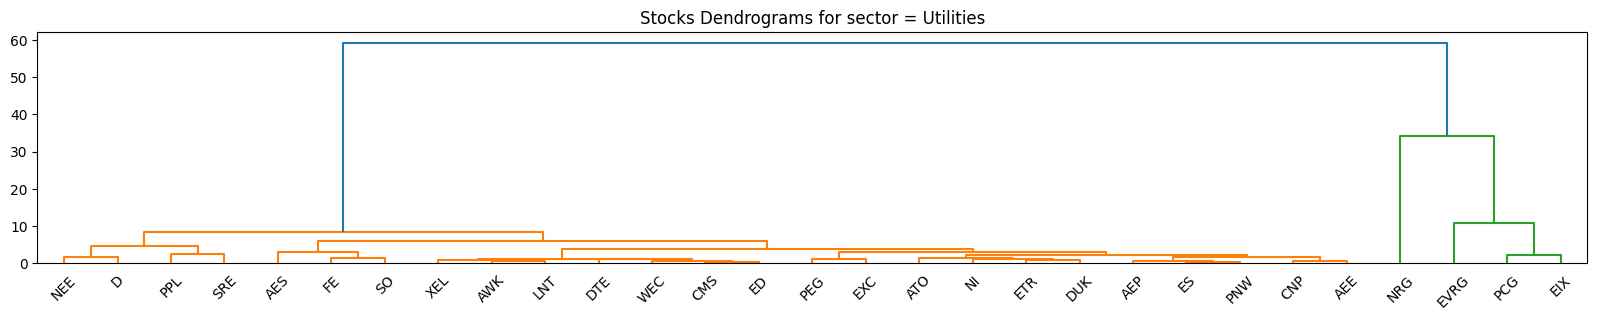

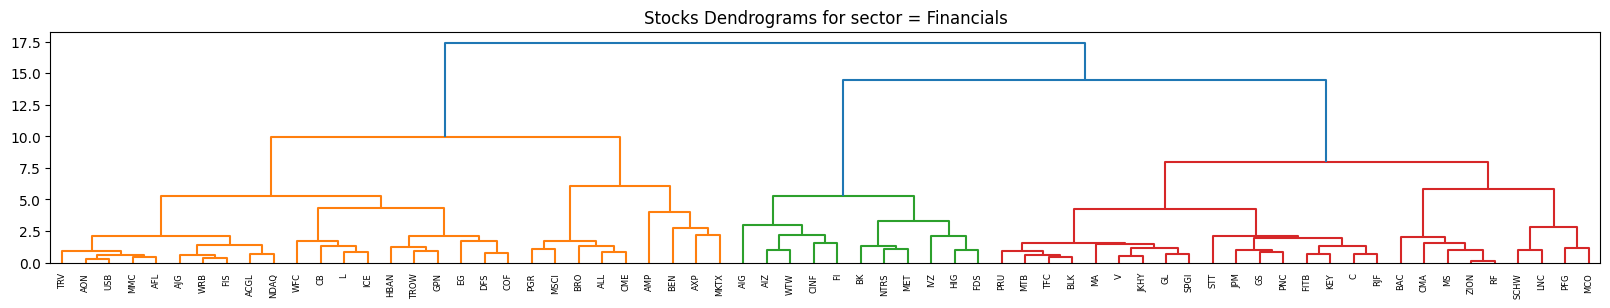

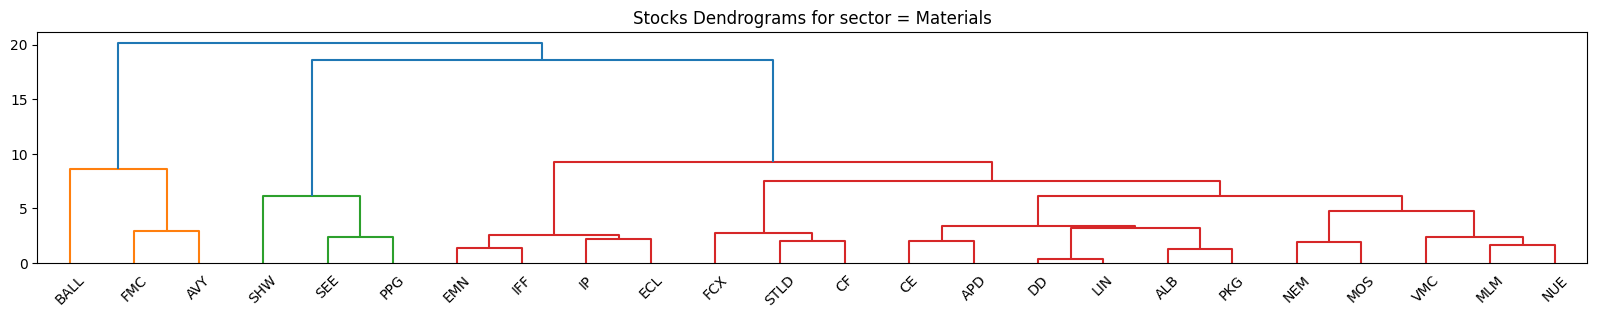

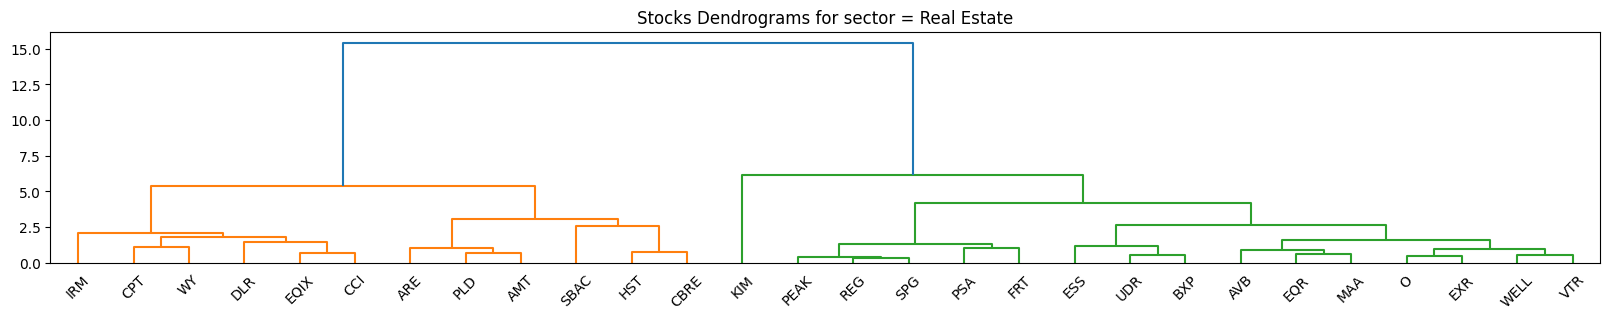

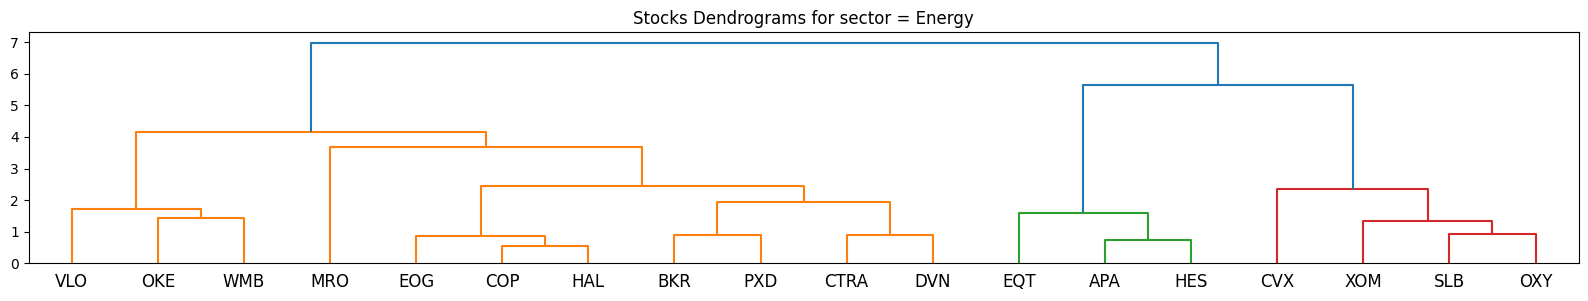

Total number of pairs to check: 6150.0


In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

# Z_sec is a dictionary which will contain the results of agglomerative clustering for
# each sector.
Z_sec = {}

for sector in sectors:
    #For each sector we cluster the stocks using Ward's distance.
    Z_sec[sector] = linkage(df_norm['train'][sector],
                            method='ward')
# Total pairs is the total number of pairs we need to check when we consider pair-trading.
total_pairs = 0
# num_clusters_dend will contain the number of clusters in a given sector.
num_clusters_dend = {}

for sector in sectors:
    # For each sector we 
    plt.figure(figsize=(20,3))
    plt.title(f"Stocks Dendrograms for sector = {sector}")
    
    dend = dendrogram(Z_sec[sector],
                      labels = df_norm['train'][sector].index)
    counts = Counter(dend['leaves_color_list'])

    num_clusters_dend[sector] = len(counts)
    
    for x in counts.values():
        total_pairs += x*(x-1)*1/2.
    plt.show()
    
print(f'Total number of pairs to check: {total_pairs}')

### Affinity

Total number of pairs to check: 1769.0


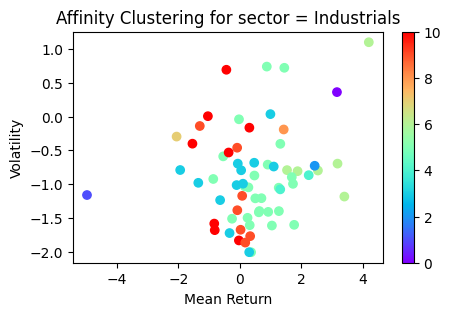

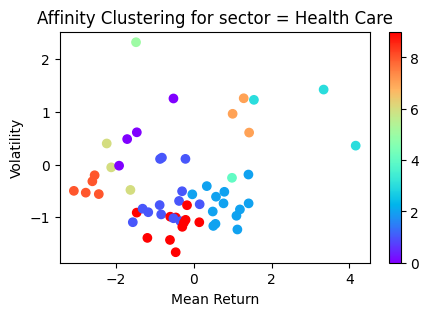

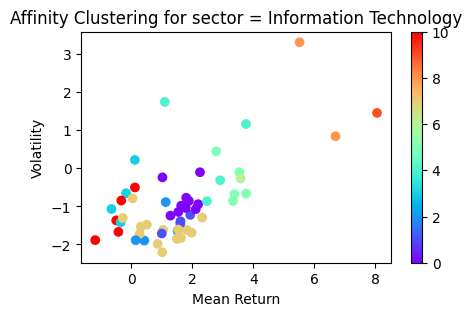

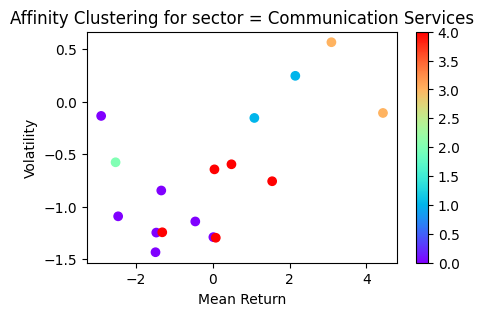

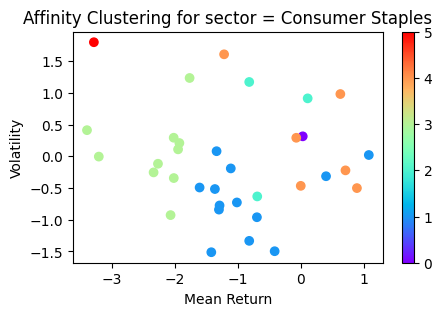

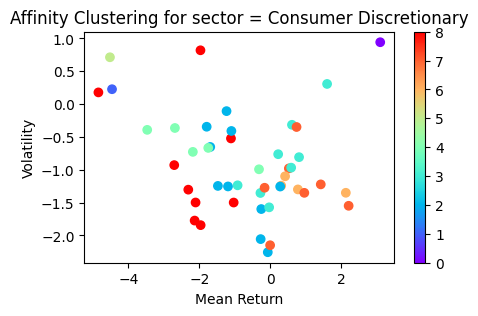

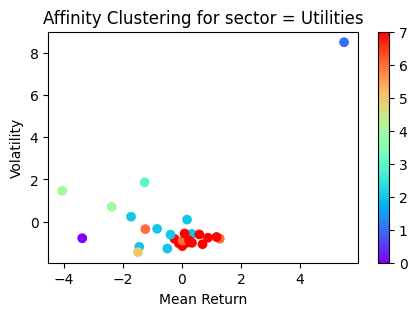

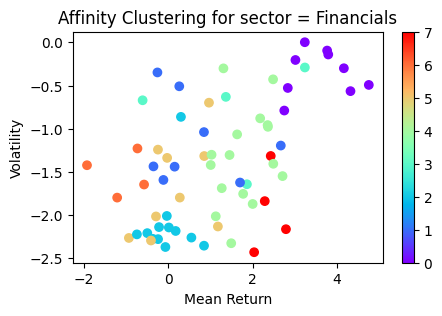

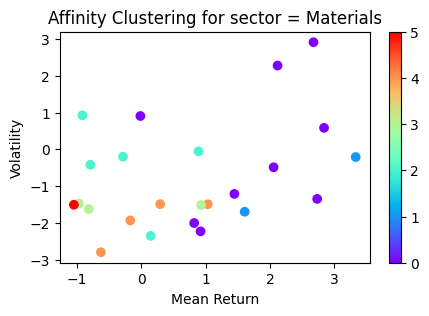

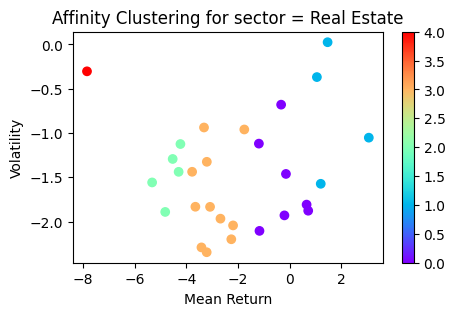

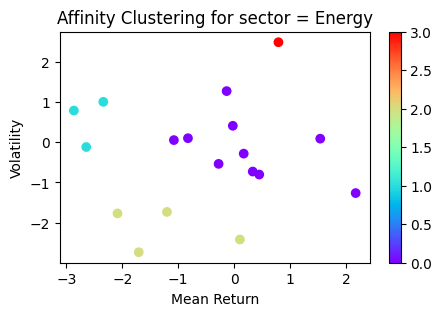

In [30]:
clust_labels_ap = {}
tot_pairs = 0

for sector in sectors:
    ap = AffinityPropagation()
    ap.fit(df_norm['train'][sector])
    clust_labels_ap[sector] = ap.predict(df_norm['train'][sector])
    
    for x in Counter(clust_labels_ap[sector]).values():
        tot_pairs += x*(x-1)*.5

print(f'Total number of pairs to check: {tot_pairs}')
        
for sector in sectors:

    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df_norm['train'][sector].iloc[:,0],df_norm['train'][sector].iloc[:,1], c= clust_labels_ap[sector], cmap ="rainbow")
    ax.set_title('Affinity')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.colorbar(scatter)
    plt.title(f'Affinity Clustering for sector = {sector}')

### Optics

Need to check 321.0 pairs


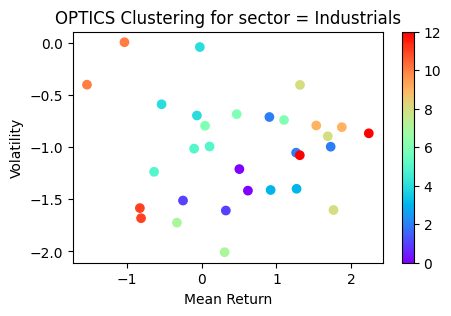

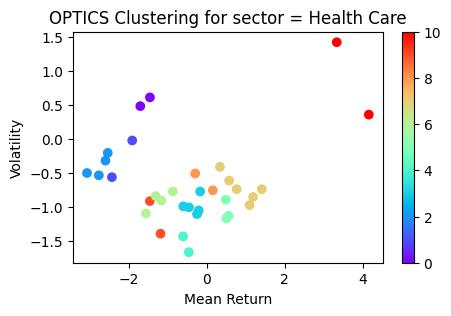

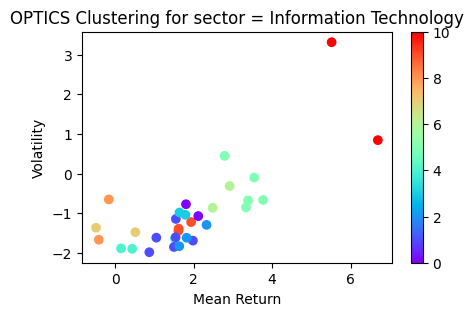

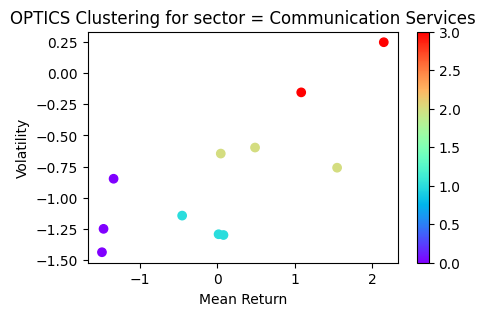

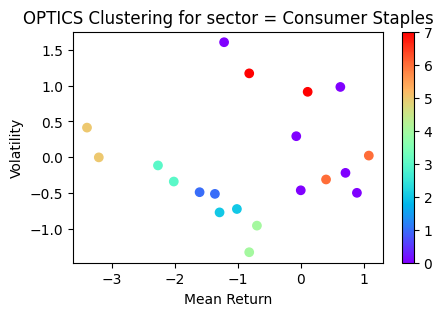

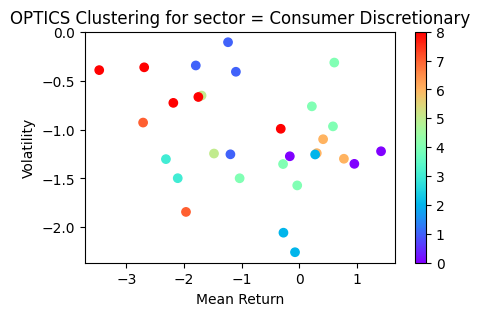

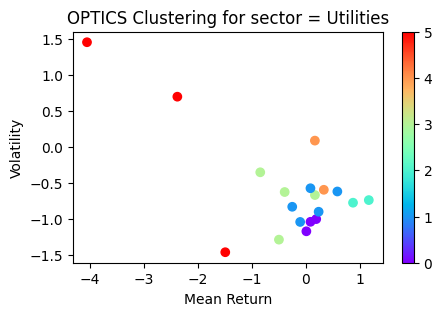

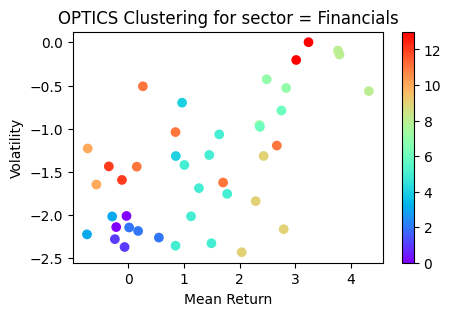

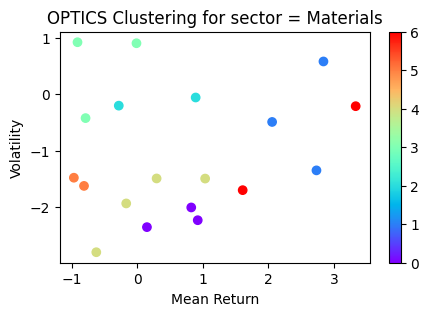

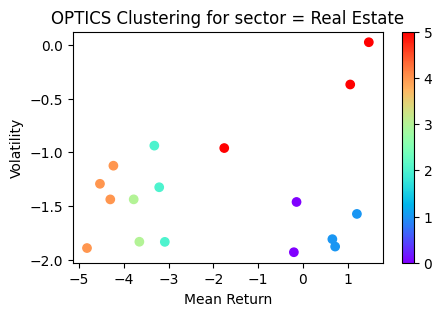

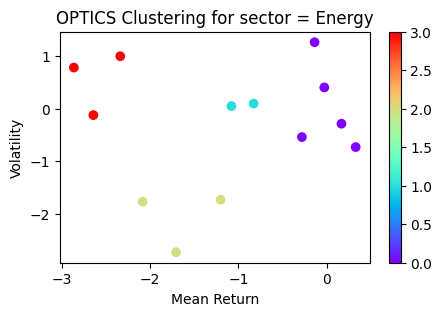

In [31]:
optics_labels = {}
sector_counts = {}

for sector in sectors:
    X = df_norm['train'][sector]
    
    optics_labels[sector] = OPTICS(min_samples=2).fit_predict(X)
    sector_counts[sector] = 0

    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    
    datapoints = list(zip(df_norm['train'][sector].iloc[:,0],df_norm['train'][sector].iloc[:,1],optics_labels[sector]))
    datapoints = np.array([data for data in datapoints if data[-1]!=-1])
    
    scatter = ax.scatter(datapoints[:,0],datapoints[:,1],c=datapoints[:,2],cmap='rainbow')
    
    #scatter = ax.scatter(df_norm['train'][sector].iloc[:,0],
    #                     df_norm['train'][sector].iloc[:,1],
    #                     c = optics_labels[sector],
    #                     cmap ="rainbow")
   
    ax.set_title('Optical Clustering')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    
    plt.colorbar(scatter)
    plt.title(f'OPTICS Clustering for sector = {sector}')
    
    counts = Counter(optics_labels[sector])
    for label, count in counts.items():
        if label == -1:
            continue
        else:
            sector_counts[sector] += count*(count-1)*.5
            
        
print(f'Need to check {sum(list(sector_counts.values()))} pairs')

# Pair Trading

Finally, we come to the problem of finding which pairs work well for pair-trading. Our full procedure is as follows:
1) We start by using the OPTICS clustering algorithm on our training dataset where we use mean, volatility, skew, and kurtosis as features. This will result in a total of 321 pairs that we need to check.

2) For each pair, we test if they are cointegrated on the training set using an in-built function statsmodels. We only keep pairs of stocks with a p-value < 0.05. For each pair of pair-integrated stocks we define the spread $S_t$ to be:
\begin{align}
S_{t} = \text{stock}_{2,t} - \beta*\text{stock}_{1,t}
\end{align}
where $\beta$ is computed using OLS.

3) For each spread we compute its Hurst exponent $H$ and only keep pairs where $H<0.5$, which indicates that the pair is mean-reverting. We then compute the half-life of the spread and only keep pairs with a half-life < 100, which ensures the time-series tends to revert back to its mean value. Finally, we only keep stocks which cross their mean at a rate of at least 12 times per year.

4) We then repeat steps (2) and (3), except this time on the validation set. As a result of all this filtering, we are left with only two pairs of stocks!

5) Finally, we define a trading strategy where we enter a long/short position if the spread is 2\*sigma below/above its mean (as measured on the validation set) and close this position when the stock is 1.5*sigma below/above the mean, respectively. We use this trading strategy on the test set and find that it is profitable (although we did not take into account transaction costs).

There are certainly many areas to improve our analysis! For one, we can try and weaken our filtering steps since the conditions we impose are likely too strong. In addition, we can improve our trading strategy by incorporating time-series analysis. For example, in our strategy we buy a stock once it goes two-sigma below the mean, but in practice it would be more useful to try and forecast when the stock has reached its minimum and try to buy it there. In addition, our trading signals are determined solely by the mean and volatility of the spread on the validation set. Our definition of the spread itself also depends on the validation set through our definition of $\beta$. In practice, it would be better to have constantly updating estimates for all these quantities since the underlying stocks will likely behave differently in the test set vs validation set. We leave the incorporation of these ideas to future updates of this notebook!

## Training Set Filtering

First, we run our clustering algorithm using all four features. We find that there are 321 pairs that we need to check.

In [35]:
optics_labels = {}
sector_counts = {}

for sector in sectors:
    X = df_norm['train'][sector]
    
    optics_labels[sector] = OPTICS(min_samples=2).fit_predict(X)
    sector_counts[sector] = 0
    
    counts = Counter(optics_labels[sector])
    for label, count in counts.items():
        if label == -1:
            continue
        else:
            sector_counts[sector] += count*(count-1)*.5
        
print(f'Need to check {sum(list(sector_counts.values()))} pairs')

Need to check 321.0 pairs


Next, we define sector_pairs, which will be a dictionary of dictionaries. For each GICS sector the dictionary sector_paris[sector] will contain keys corresponding to the cluster labels and the associated value is a list of all the stocks in that cluster. We do not include the cluster with label = -1 since these are stocks which the OPTICS algorithm could not group into *any* cluster. In addition, we remove any clusters which contain a single stock since we want to compare pairs of stocks. 

In [36]:
sector_pairs={}
for sector in sectors:
    sector_pairs[sector] = defaultdict(list)
    for ticker,label in zip(df_norm['train'][sector].index, optics_labels[sector]):
        if label == -1:
            continue
        sector_pairs[sector][label].append(ticker)
    
    for label in np.arange(np.max(optics_labels[sector])+1):
        if len(sector_pairs[sector][label])<=1:
            del sector_pairs[sector][label]

We then define the dictionary p_values which will contain the p-values for our co-integration test. Specifically, the keys of p_values are the pairs of stocks we are testing and the associated value is the p-value for them being cointegrated.

In [37]:
p_values = {}

for sector in sectors:
    print(sector)
    for label in tqdm(sector_pairs[sector].keys()):
        pairs_test =  list(itertools.combinations(sector_pairs[sector][label],2))

        for pair in pairs_test:
            stock_1, stock_2 = pair
            result = coint(df['train'][stock_1],df['train'][stock_2])
            score = result[0]
            pvalue = result[1]

            p_values[(stock_1,stock_2)] = pvalue

Industrials


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.69it/s]


Health Care


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  2.90it/s]


Information Technology


100%|███████████████████████████████████████████| 11/11 [00:07<00:00,  1.53it/s]


Communication Services


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]


Consumer Staples


100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.68it/s]


Consumer Discretionary


100%|█████████████████████████████████████████████| 9/9 [00:04<00:00,  2.12it/s]


Utilities


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  3.00it/s]


Financials


100%|███████████████████████████████████████████| 14/14 [00:07<00:00,  1.96it/s]


Materials


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


Real Estate


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.66it/s]


Energy


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


After computing all the p-values we only keep pairs of stocks where the p-value < 0.05, which indicates there is a strong likelihood the stocks are co-integrated.

In [ ]:
tot=0
stocks_coint = []
for stocks, val in p_values.items():
    if val<0.05:
        stocks_coint.append(stocks)
        tot += 1
print(tot)

Next, for each pair of stocks in the stocks_coint list we perform OLS to regress one stock on the other. The $\beta$ parameter is used to define the spread of the co-integrated pair.

In [40]:
spreads = {}
betas = {}

for stock_pairs in stocks_coint:
    S1, S2 = stock_pairs
    X = df['train'][S1]
    Y = df['train'][S2]
    
    model = OLS(Y,add_constant(X)).fit()
    beta = model.params[S1]
    
    betas[stock_pairs] = beta
    
    spreads[S1,S2] = Y.values - beta * X.values

In the below cell we compute the Huerst exponent for each spread and only keep pairs of stocks which have exponent < 0.5, which indicates the spread is mean-reverting.

In [41]:
Hc_filt = []

for stock_pairs in stocks_coint:
    if compute_Hc(spreads[stock_pairs])[0]<0.5:
        Hc_filt.append(stock_pairs)

Next, we compute the half-life for each spread. Since the spread is given by an AR(1) process (this can be checked empirically), we can use the formula:
\begin{align}
h = -\log(2)/\log(|\phi_1|)
\end{align}
where $\phi_1$ is the coefficient of the one-lagged term, i.e. $X_{t}=c+\phi X_{t-1}+\epsilon_t$ where $\epsilon$ is white-noise and $c$ is a constant. We only keep stocks with a half life between 1 and 100 days.

In [42]:
pairs_hf = []

for pair in Hc_filt:

    phi_1 = AutoReg(spreads[pair],lags=1).fit().params[1]    
    halflife = np.log(0.5)/np.log(phi_1)
                                  
    if 1 < halflife < 100:
        pairs_hf.append(pair)

Finally, we take the spread, subtract its mean, and count how many times the (de-meaned) spread crosses zero. We only keep the pair if the spread crosses the mean at a rate of more than 12 times per year.

In [43]:
pairs_mean_crossing = []

for pair in pairs_hf:
    ct=0
    S1, S2 = pair
    spread = spreads[S1,S2]
    
    spread = spread - spread.mean()
    length = spread.shape[0]
    
    for i in range(1,length):
        if spread[i]*spread[i-1]<0:
            ct+=1
    
    if ct>12*length/252:
        pairs_mean_crossing.append(pair)

## Validation Set Filtering

In this subsection we repeat the above filtering process, except now on the validation set. We will be brief here since the analysis is the same as before, but we again test if the stocks are co-integrated and require that the spread is mean-reverting, has a half-lie between 1 and 100 days, and that it crosses its mean at a rate of more than 12 times per year.

In [46]:
coint_valid = []

for pair in pairs_mean_crossing:
    S1, S2 = pair
    result = coint(df['valid'][S1],df['valid'][S2])
    score = result[0]
    pvalue = result[1]
    

    if pvalue < 0.05:
        coint_valid.append(pair)

In [47]:
spreads_valid = {}
betas_valid = {}

for stock_pairs in coint_valid:
    S1, S2 = stock_pairs
    X = df['valid'][S1]
    Y = df['valid'][S2]
    
    model = OLS(Y,add_constant(X)).fit()
    beta = model.params[S1]
    
    betas_valid[stock_pairs] = beta
    
    spreads_valid[S1,S2] = Y.values - beta * X.values

In [48]:
Hc_filt_valid = []

for stock_pairs in coint_valid:
    if compute_Hc(spreads_valid[stock_pairs])[0]<0.5:
        Hc_filt_valid.append(stock_pairs)

In [49]:
pairs_hf_valid = []

for pair in Hc_filt_valid:

    phi_1 = AutoReg(spreads_valid[pair],lags=1).fit().params[1]    
    halflife = np.log(0.5)/np.log(phi_1)
                                  
    if 1 < halflife < 100:
        pairs_hf_valid.append(pair)

In [60]:
pairs_mean_crossing_valid = []

for pair in pairs_hf_valid:
    ct=0
    S1, S2 = pair
    spread_valid = spreads_valid[S1,S2]
    
    spread_valid = spread_valid - spread_valid.mean()
    length = spread_valid.shape[0]
    
    for i in range(1,length):
        if spread_valid[i]*spread_valid[i-1]<0:
            ct+=1
    
    if ct>12*length/252:
        pairs_mean_crossing_valid.append(pair)

## Returns on Test Set

In this section we set up our pair-trading strategy. Below we estimate the mean and volatility of the spread on the test set using the corresponding values on the validation set.

In [72]:
means_val = {}
stds_val = {}

for pair in pairs_mean_crossing_valid:
    S1, S2 = pair
    
    means_val[pair] = spreads_valid[pair].mean()
    stds_val[pair] = spreads_valid[pair].std()

Next, we compute the spread on the test set using the $\beta$'s we found by performing OLS on the validation set.

In [73]:
spreads_test = {}

for pair in pairs_mean_crossing_valid:
    S1, S2 = pair
    spreads_test[pair] = df['test'][S2] - betas_valid[pair]*df['test'][S1]

Finally, the code below sets up the trading strategy. We go through the important parameters below.

* **returns**: This is a dictionary containing our main results, the returns we would earn by performing pair trading on a given pair of stocks. The keys correspond to the pairs of stocks $(S1,S2)$ and the associated value is a list corresponding to the value of this strategy as a function of time.

* **buy_longs**: This is again a dictionary whose keys are the stock pairs and whose values are lists. Each element of this list is a tuple (time, price) corresponding to the time at which we buy a stock and the price at which we buy it. The dictionary **sell_longs** has the same structure, but its values are a list of tuples containing the price at which we've sold our long position and the value we've earned. The dictionaries **buy_shorts** and **sell_shorts** are the same, except for when we buy/sell a short position.

* The parameters (**buy_long_signal**,**sell_long_signal**) determine at value of the stock we buy or sell a long position. The parameters (**buy_short_signal**,**sell_short_signal**) are the same, except for a short-position.

* In our simple set-up we assume that there is no slippage when we buy stocks (when we place a buy order we pick up the stock immediately) but when we sell a stock we need to wait one day before the trade is executed. This assumption can of course be modified to reflect more realistic set-ups.

* Finally, we impose that we do not hold any positions at the end of our trading time.

In [74]:
returns = {}

buy_longs = defaultdict(list)
sell_longs = defaultdict(list)
buy_shorts = defaultdict(list)
sell_shorts = defaultdict(list)

for pair in pairs_mean_crossing_valid:
    
    returns[pair] = [0]
    
    hold_long = False
    hold_short = False
    sell_long_order = False
    sell_short_order = False
    
    total_time = spreads_test[pair].shape[0]
    
    for i, price in enumerate(spreads_test[pair]):
        change=0

        buy_long_signal = means_val[pair] - 2*stds_val[pair]
        sell_long_signal = means_val[pair] - 1.5*stds_val[pair]
        
        buy_short_signal = means_val[pair] + 2*stds_val[pair]
        sell_short_signal = means_val[pair] + 1.5*stds_val[pair]

        if sell_long_order or (i==total_time-1 and hold_long):
            change = price 
            sell_long_order = False
            sell_longs[pair].append((i,price))

        elif sell_short_order or (i==total_time-1 and hold_short):
            change = -price
            sell_short_order = False
            sell_shorts[pair].append((i,price))

        elif price <= buy_long_signal and hold_long == False and i<=total_time-3:
            change = -price
            hold_long = True
            buy_longs[pair].append((i,price))

        elif price >= sell_long_signal and hold_long == True:
            hold_long = False
            sell_long_order = True

        elif price >= buy_short_signal and hold_short == False and i<=total_time-3:
            change = price
            hold_short = True
            buy_shorts[pair].append((i,price))

        elif price <= sell_short_signal and hold_short == True:
            hold_short = False
            sell_short_order = True
        
        returns[pair].append(returns[pair][-1]+change)

Overall we find a small profit! Pair trading has earned us around $55.45 when we only buy/sell one unit of the spread at a time.

In [75]:
for pair in spreads_test:
    print(f'Returns on pair {pair} is {returns[pair][-1]}')

Returns on pair ('TMO', 'BDX') is 50.540832062229384
Returns on pair ('CMS', 'AWK') is 4.911445677312642


Finally, in the plots we demonstrate when our trades take place. Blue and red X's correspond to opening and closing a short-position, respectively. Similarly, blue and red dots correspond to opening and closing a long position. The green lines correspond to $\pm2\sigma$ above and below the mean, as estimated using data from the validation set.

('TMO', 'BDX')


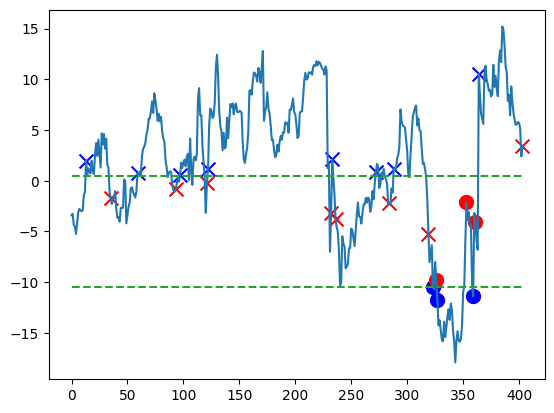

('CMS', 'AWK')


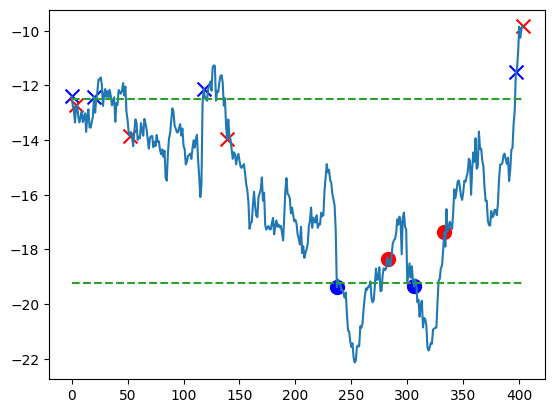

In [77]:
for key in spreads_test:
    print(key)

    try:
        plt.scatter(*zip(*buy_longs[key]),c='b',s=100)
        plt.scatter(*zip(*sell_longs[key]),c='r',s=100)
    except:
        pass

    try:
        plt.scatter(*zip(*buy_shorts[key]),c='b',marker='x',s=100)
        plt.scatter(*zip(*sell_shorts[key]),c='r',marker='x',s=100)
    except:
        pass

    plt.plot(spreads_test[key].values)
    
    plt.hlines(y=means_val[key]+2*stds_val[key],
               xmin=0,
               xmax=len(spreads_test[key])-1,
               linestyles='dashed',
               colors='C2')
    
    plt.hlines(y=means_val[key]-2*stds_val[key],
               xmin=0,
               xmax=len(spreads_test[key])-1,
               linestyles='dashed',
               colors='C2')

    plt.show()